# ID The Composer Algorithm
##A Deep Learning Neural Network for Composer Identification

###Overview & Goals
This code is designed to ingest music files to train deep learning models in order to identify the composer based on the music alone. The primary objective is to develp a deep learnign model that can predict the composer of a given musical score accurately.

The project aims to accomplish this objective by using two deep learning techniques: Long Short-Term Memory (LSTM) and Convolutional Neural Network (CNN).

This project is part of the Master's In Applied Artificial Intelligence program at the University of San Diego.

###Methodology for this Project
1. Data Collection (data provided via kaggle, workflow via Google Drive)
2. Data Pre-processing: Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI files and applying data augmentation techniques.
3. Feature Extraction: Extract features from the MIDI files, such as notes, chords, and tempo, using music analysis tools.
4. Model Building: Develop a deep learning model using LSTM and CNN architectures to classify the musical scores according to the composer.
5. Model Training: Train the deep learning model using the pre-processed and feature-extracted data.
6. Model Evaluation: Evaluate the performance of the deep learning model using accuracy, precision, and recall metrics.
7. Model Optimization: Optimize the deep learning model by fine-tuning hyperparameters.




#Data Download

In [1]:
!pip install kaggle
!pip install pretty_midi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 27.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.6 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=dbc8e14d7f4cc753e896c187a5e6f6bd08b312cd440b415ca4a34d97f259bbe6
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [2]:
# ===== Standard Library =====
import os
import re
import ast
import random
import shutil
import zipfile
from zipfile import ZipFile
import warnings
from itertools import cycle
from datetime import datetime

# ===== Third-Party Libraries =====
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import mido
import pretty_midi
import pretty_midi as pm
import kagglehub as kagglehub  # Wire to Kaggle?

# ===== Scikit-learn =====
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, auc,
    roc_auc_score, average_precision_score, precision_recall_curve,
    RocCurveDisplay, top_k_accuracy_score
)

# ===== TensorFlow / Keras =====
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [3]:
NB_START = datetime.now()
print(f"Started at: {NB_START:%Y-%m-%d %H:%M:%S}")

Started at: 2025-08-10 06:36:12


#### This section defines configuration constants and sets a global random seed for reproducibility in the project.

*Environment Detection:* The IS_GOOGLE_COLAB flag determines whether the notebook is running in a cloud environment or locally, changing where datasets are stored accordingly.

*Composer List:* The composers variable defines the exact set of classes (Bach, Beethoven, Chopin, Mozart) that the deep learning model will classify.

*Dataset ID:* DATASET_ID stores the Kaggle dataset identifier, which will be used to download the data at runtime.

*Dataset Paths:* while MIDI_DATA_DIR, DESTINATION_DIR, and SOURCE_DATA_DIR specify storage locations for MIDI files, both for Colab and local execution.

*File Type Filtering:* The SUPPORTED_EXT list ensures only .mid and .midi files are processed.


In [4]:
#Set desired file path
IS_GOOGLE_COLAB = True
COMPOSERS = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
DATASET_ID = "blanderbuss/midi-classic-music"
MIDI_DATA_DIR = '/content/midi_data'
DESTINATION_DIR = "/tmp"
SOURCE_DATA_DIR = DESTINATION_DIR
SUPPORTED_EXT = ['.mid', '.midi']

if IS_GOOGLE_COLAB == False:
    MIDI_DATA_DIR = os.path.join(os.getcwd(), 'midi_data')

*Random Seed Initialization:* The set_random_seed function ensures reproducibility across multiple libraries (Python, NumPy, TensorFlow) by fixing pseudo-random number generators.

In [5]:
#Set universal random seed for codeset
SEED = 42

def set_random_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_random_seed(SEED)

Code to cleanup the folders and file created. Useful in case of user is running the code multiple times. This will get the latest updated data and be in sync with any change in source data over the time.

In [6]:
# ----------------------------------
# Delete a folder and all its contents
# ----------------------------------
def delete_folder_recursive(folder_path):

    if os.path.exists(folder_path):
        try:
            shutil.rmtree(folder_path)
            print(f" Deleted folder and its contents: {folder_path}")
        except Exception as e:
            print(f"[ERROR] Failed to delete {folder_path}: {e}")
    else:
        print(f"[INFO] Folder does not exist: {folder_path}")

delete_folder_recursive("/content/midi_data")

[INFO] Folder does not exist: /content/midi_data


# Download, extract data from zip and organize in folder

Downloads the dataset from Kaggle using kagglehub. Copies it into the specified local directory (DESTINATION_DIR). Extracts all .zip archives, including nested zips, ensuring the deepest levels of compressed data are accessible. Organizes MIDI files into composer-specific folders.

In [7]:
# -------------------------------
# Download Dataset via KaggleHub
# -------------------------------
def download_dataset(dataset_id):
    # Print the dataset being downloaded
    print(f"Downloading dataset: {dataset_id}")
    # Use KaggleHub API to download the dataset to a temporary location
    dataset_path = kagglehub.dataset_download(dataset_id)
    # Notify user of the download location
    print(f"Dataset downloaded to temporary path: {dataset_path}")
    return dataset_path

# -------------------------------
# Copy Dataset to Destination
# -------------------------------
def copy_dataset(source_path, destination_path):
    # Create destination folder if it does not exist
    if not os.path.exists(destination_path):
        os.makedirs(destination_path)
        print(f"Created destination folder: {destination_path}")

    try:
        # Copy entire dataset directory to destination (allowing overwrite)
        shutil.copytree(source_path, destination_path, dirs_exist_ok=True)
        print(f"Dataset copied from '{source_path}' to '{destination_path}'")
    except Exception as e:
        print(f"[ERROR] Could not copy dataset: {e}")

# ----------------------------------
# Create base output folder and composer folders
# ----------------------------------
def create_composer_folders(base_dir, composers):
    # Ensure base output directory exists
    os.makedirs(base_dir, exist_ok=True)
    # Create subfolder for each composer
    for composer in composers:
        composer_dir = os.path.join(base_dir, composer)
        os.makedirs(composer_dir, exist_ok=True)

# ----------------------------------
# Recursively extract all .zip files in a directory
# ----------------------------------
def extract_all_nested_zips(base_path):
    # Traverse all directories and files within base_path
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith('.zip'):
                zip_path = os.path.join(root, file)
                extract_path = os.path.splitext(zip_path)[0]
                # Extract contents of the ZIP file
                try:
                    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                        zip_ref.extractall(extract_path)
                        #print(f"Extracted: {zip_path} -> {extract_path}")
                except zipfile.BadZipFile:
                    print(f"[WARNING] Skipped invalid ZIP: {zip_path}")
                    continue
                except Exception as e:
                    print(f"[ERROR] Failed to extract {zip_path}: {e}")
                    continue
                # Recursively extract deeper levels
                extract_all_nested_zips(extract_path)

# ----------------------------------
# Copy .midi files to composer folders
# ----------------------------------
def copy_midi_files_to_composer_folders(source_dir, target_dir, composers):
    # Walk through all files and directories in the source
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            # Process only .mid or .midi files
            if file.lower().endswith('.mid') or file.lower().endswith('.midi'):
                full_path = os.path.join(root, file)
                for composer in composers:
                    if composer.lower() in full_path.lower():
                        destination = os.path.join(target_dir, composer, file)
                        try:
                            shutil.copy2(full_path, destination)
                            #print(f"Copied: {full_path} -> {destination}")
                        except Exception as e:
                            print(f"[ERROR] Failed to copy {full_path}: {e}")
                        break

# ----------------------------------
# Orchestrator function
# ----------------------------------
def organize_midi_data():
    # Create output structure
    create_composer_folders(MIDI_DATA_DIR, COMPOSERS)

    # Extract all ZIPs (even nested)
    extract_all_nested_zips(SOURCE_DATA_DIR)

    # Copy relevant .midi files to target composer folders
    copy_midi_files_to_composer_folders(SOURCE_DATA_DIR, MIDI_DATA_DIR, COMPOSERS)

# ----------------------------------
# Print summary of .mid/.midi files per composer
# ----------------------------------
def print_midi_file_summary(composer_dir, composers):
    summary = {}

    for composer in composers:
        folder_path = os.path.join(composer_dir, composer)
        count = 0

        # Count .mid and .midi files only
        for file in os.listdir(folder_path):
            ext = os.path.splitext(file)[1].lower()
            if ext in SUPPORTED_EXT:
                count += 1

        summary[composer] = count

    print("\n MIDI File Summary per Composer:")
    print("----------------------------------")
    for composer, count in summary.items():
        print(f"{composer}: {count} files")

# -------------------------------
# Full Setup Pipeline
# -------------------------------
def setup_dataset():
    source = download_dataset(DATASET_ID)
    copy_dataset(source, DESTINATION_DIR)
    organize_midi_data()


setup_dataset()
print_midi_file_summary(MIDI_DATA_DIR, COMPOSERS)

Dataset downloaded to temporary path: /kaggle/input/midi-classic-music
Dataset copied from '/kaggle/input/midi-classic-music' to '/tmp'

 MIDI File Summary per Composer:
----------------------------------
Bach: 1050 files
Beethoven: 220 files
Chopin: 138 files
Mozart: 259 files


# LSTM Model

### **Data Pre-Processing & Feature Extraction**

Discovers, labels, and indexes MIDI files for four classes (Bach, Beethoven, Chopin, Mozart):

It recursively scans base_dir for files with extensions in supported_ext.

It assigns each file to the first composer whose name appears in the file path (case‑insensitive).

For supervised learning, we require pairs (𝑥𝑖,𝑦𝑖) where  𝑥𝑖 is a MIDI file path and 𝑦𝑖∈{Bach,Beethoven,Chopin,Mozart}, which is the canonical input to LSTM

In [8]:
def get_composer_midis(base_dir, composers, supported_ext=('.mid', '.midi')):
    """
    Finds MIDI file paths for selected composers in base_dir and returns a DataFrame and a dict mapping composers to their files.

    Args:
        base_dir (str): Path to search.
        composers (list): List of composer names (strings).
        supported_ext (tuple): Tuple of allowed file extensions.

    Returns:
        df (pd.DataFrame): DataFrame of matching files and composers.
        composer_files (dict): Dict of composer name to list of filepaths.
    """
    matched_paths = []

    for root, dirs, files in os.walk(base_dir):
        for f in files:
            file_path = os.path.join(root, f)
            if file_path.lower().endswith(supported_ext):
                for composer in composers:
                    if composer.lower() in file_path.lower():
                        matched_paths.append({'filepath': file_path, 'composer': composer})
                        break  # Only assign first matching composer

    # Create DataFrame
    df = pd.DataFrame(matched_paths)
    pd.set_option('display.max_colwidth', None)

    # Drop any rows where composer is not found (shouldn't happen here, but kept for safety)
    df = df.dropna(subset=['composer'])

    # Collect filepaths for each composer
    composer_files = {composer: df[df['composer'] == composer]['filepath'].tolist() for composer in composers}

    # Print stats
    for composer, files in composer_files.items():
        print(f"{composer}: {len(files)} files")

    return df, composer_files


df, composer_files = get_composer_midis(MIDI_DATA_DIR, COMPOSERS)
print(df)

Bach: 1050 files
Beethoven: 220 files
Chopin: 138 files
Mozart: 259 files
                                                                       filepath  \
0                       /content/midi_data/Mozart/K317 Coronation Mass 6mov.mid   
1                      /content/midi_data/Mozart/K309 Piano Sonata n10 2mov.mid   
2              /content/midi_data/Mozart/K608 Fantasia for Mechanical Organ.mid   
3              /content/midi_data/Mozart/Symphony n41 K551 2mov ''Jupiter''.mid   
4                           /content/midi_data/Mozart/Piano Sonata n07 K309.mid   
...                                                                         ...   
1662       /content/midi_data/Beethoven/Sonata No.14 Op 27 Moonlight Sonata.mid   
1663                 /content/midi_data/Beethoven/Piano Sonatina No.2 Op 49.mid   
1664                         /content/midi_data/Beethoven/Bagatella op33 n4.mid   
1665               /content/midi_data/Beethoven/Symphony n3 4mov ''Eroica''.mid   
1666  /conten

In [9]:
df.head()

,filepath,composer
0,/content/midi_data/Mozart/K317 Coronation Mass 6mov.mid,Mozart
1,/content/midi_data/Mozart/K309 Piano Sonata n10 2mov.mid,Mozart
2,/content/midi_data/Mozart/K608 Fantasia for Mechanical Organ.mid,Mozart
3,/content/midi_data/Mozart/Symphony n41 K551 2mov ''Jupiter''.mid,Mozart
4,/content/midi_data/Mozart/Piano Sonata n07 K309.mid,Mozart


Addresses class imbalance in the dataset by downsampling the overrepresented Bach class:
Downsampling Bach – Keeps only 60% of Bach’s entries (bach_frac=0.6) using a fixed random seed for reproducibility.

Preserving Other Classes – Keeps all samples from Beethoven, Chopin, and Mozart, but shuffles them within each composer group.

Combining & Shuffling – Merges the reduced Bach set with all other composers, then shuffles the combined dataset to randomize order.

Class imbalance, particularly extreme overrepresentation of one class, can bias supervised learning models toward predicting the majority class. Bach 1050 files (≈ 65% of the dataset) risk overshadowing patterns from Beethoven, Chopin, and Mozart.


If $N_b$ is the number of Bach samples, the target is:

$$
N_b' = \lfloor \text{bach\_frac} \times N_b \rfloor
$$

The balanced dataset size $N'$ becomes:

$$
N' = N_b' + \sum_{c \neq \text{Bach}} N_c
$$

For your numbers:

$$
N_b' = 0.6 \times 1050 = 630
$$

$$
N' = 630 + (220 + 138 + 259) = 1247
$$


Bach’s entries have been reduced from 1050 → 630.
Beethoven (220), Chopin (138), and Mozart (259) remain unchanged.
Total files now: 1247, down from 1667.
This means class ratio disparity is reduced from roughly 65% Bach dominance to 50% Bach / 50% others, improving the fairness of gradient updates in CNN/LSTM training.



In [10]:
def balance_bach_dataset(df, bach_name='Bach', seed=42, bach_frac=0.6):
    """
    Downsample Bach's entries while keeping other composers' data intact.

    Args:
        df (pd.DataFrame): DataFrame with at least 'composer' column.
        bach_name (str): Name of the composer to downsample.
        seed (int): Random seed for reproducibility.
        bach_frac (float): Fraction of Bach's data to keep.

    Returns:
        pd.DataFrame: Balanced and shuffled DataFrame.
    """
    # Select only Bach rows and randomly sample a fraction of them
    df_bach = df[df['composer'] == bach_name].sample(frac=bach_frac, random_state=seed)

    # Select all non-Bach rows, grouped by composer, and shuffle within each group
    df_others = (
        df[df['composer'] != bach_name]
        .groupby('composer', group_keys=False)
        .sample(frac=1, random_state=seed)
    )

    # Concatenate the downsampled Bach rows with the full set of other composers' rows
    df_sampled = pd.concat([df_bach, df_others]).reset_index(drop=True)
    # Shuffle the combined DataFrame to mix Bach and other composers
    df_sampled = df_sampled.sample(frac=1.0, random_state=seed).reset_index(drop=True)

    # Print the total number of rows after balancing
    print(f"Total files after balancing: {len(df_sampled)}")
    # Return the balanced and shuffled dataset
    return df_sampled

df = balance_bach_dataset(df, bach_name='Bach', seed=SEED, bach_frac=0.6)


Total files after balancing: 1247


Normalize each MIDI so that timing/key metadata (set_tempo, key_signature, time_signature) live in track 0, a common convention that prevents downstream parsers from choking, while keeping all other messages in their original (non‑zero) tracks. Files that are not valid MIDI (e.g., missing MThd) or have unparseable key signatures are skipped, not fatal to the batch.

Many MIDI toolchains assume global score metadata (tempo, time signature, key) is resident in track 0; scattering such events across multiple tracks can cause downstream feature extractors (e.g., piano‑roll generation, quantization) to infer inconsistent temporal grids or pitch contexts, which subsequently hurts training stability for LSTM models. This step creates a canonical for each MIDI 𝑀 by relocating a subset of meta events into the global track while preserving all performance events. This transformation reduces schema variance prior to feature extraction, thereby stabilizing statistical properties that the LSTM (temporal dependencies) will learn.





In [11]:
# Sanitize MIDI files to normalize meta events and skip problematic files
def sanitize_midi(input_path, output_path=None):
    # Wrap I/O and parsing in a protective try/except to handle malformed files
    try:
        # Parse the MIDI file into a Mido MidiFile object (raises if header is invalid)
        mid = mido.MidiFile(input_path)
        # Accumulate meta events that should live globally (track 0)
        global_events = []
        # Initialize a new track list with an empty track 0 placeholder
        new_tracks = [mido.MidiTrack()]
        # Iterate through original tracks with their index to detect track 0 vs others
        for i, track in enumerate(mid.tracks):
            # Create a fresh track to hold sanitized events from this original track
            new_track = mido.MidiTrack()
            # Iterate through all messages in this track
            for msg in track:
                # Identify timing/key signature meta that must live in track 0 for many tools
                if msg.is_meta and msg.type in ['set_tempo', 'key_signature', 'time_signature']:
                    # If this is NOT the global track (i != 0), defer to global_events
                    if i != 0:
                        global_events.append(msg)
                    else:
                        # If already in track 0, keep it in the current (new) track
                        new_track.append(msg)
                else:
                    # All other messages are copied as‑is to this track’s sanitized version
                    new_track.append(msg)
            # For non‑zero tracks, append the sanitized track to the track list
            if i != 0:
                new_tracks.append(new_track)
        # After processing all tracks, append the collected global meta to track 0
        new_tracks[0].extend(global_events)
        # Replace the MidiFile’s tracks with the sanitized list
        mid.tracks = new_tracks
        # Choose output destination: overwrite input by default or write to output_path if given
        output = output_path or input_path
        # Persist the sanitized MIDI back to disk
        mid.save(output)
    except Exception as e:
        if 'KeySignatureError' in str(e) or 'Could not decode key' in str(e):
            print(f"[SKIP] {input_path}: {e}")
        else:
            print(f"[ERROR] {input_path}: {e}")
        raise #Ensure calling code also sees error for handling

successful_paths = []
failed_paths = []

for path in tqdm(df['filepath'], desc="Sanitizing MIDI files"):
    try:
        sanitize_midi(path)
        successful_paths.append(path)  # Only add if sanitize did NOT raise an exception
    except Exception as e:
        failed_paths.append(path)      # Log failures for later inspection
        tqdm.write(f"[SKIP/ERROR] {path}: {e}")

Sanitizing MIDI files:  41%|████      | 508/1247 [00:51<01:24,  8.73it/s]

[ERROR] /content/midi_data/Chopin/chopin7.mid: MThd not found. Probably not a MIDI file
[SKIP/ERROR] /content/midi_data/Chopin/chopin7.mid: MThd not found. Probably not a MIDI file


Sanitizing MIDI files:  57%|█████▋    | 715/1247 [01:13<00:31, 16.83it/s]

[SKIP] /content/midi_data/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
[SKIP/ERROR] /content/midi_data/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


Sanitizing MIDI files:  79%|███████▉  | 988/1247 [01:42<00:20, 12.94it/s]

[SKIP] /content/midi_data/Mozart/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
[SKIP/ERROR] /content/midi_data/Mozart/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


Sanitizing MIDI files: 100%|██████████| 1247/1247 [02:11<00:00,  9.48it/s]


In [12]:
#Print length of successful and failed files
print("Total df before sanitation:", len(df))
print("Successful files:", len(successful_paths))
print("Failed files:", len(failed_paths))
#Update df with successful_paths
df = df[df['filepath'].isin(successful_paths)]

#Print length of df to confirm
print(len(df))

Total df before sanitation: 1247
Successful files: 1244
Failed files: 3
1244


In [13]:
# Define function to extract statistical features from MIDI files
def compute_statistical_midi_features(midi_file_path):
    """
    Extracts statistical features from a MIDI file for composer classification.
    These features represent the style, complexity, and structure of the music,
    and are used in classical ML models (RandomForest, XGBoost) for prediction.
    """

    # Load the MIDI file using PrettyMIDI for feature extraction
    midi_obj = pm.PrettyMIDI(midi_file_path)

    # Extract all note events from non-drum instruments (focus on melodic/harmonic elements)
    note_list = [note for instr in midi_obj.instruments if not instr.is_drum for note in instr.notes]

    # Sort notes by their start time to compute inter-onset intervals (IOI) correctly
    note_list.sort(key=lambda n: n.start)

    # Extract pitches from notes (MIDI note numbers, e.g., 60 = Middle C)
    pitch_values = [note.pitch for note in note_list]

    # Extract note durations (end time - start time) to analyze rhythm patterns
    duration_values = [note.end - note.start for note in note_list]

    # Extract velocities (note intensity, related to loudness or emphasis)
    velocity_values = [note.velocity for note in note_list]

    # Compute inter-onset intervals (IOI): time difference between consecutive note starts
    iois = [note_list[i].start - note_list[i-1].start for i in range(1, len(note_list))]

    # Extract tempo (beats per minute). Use first tempo value or default to 120 BPM if missing.
    tempo_changes = midi_obj.get_tempo_changes()[1]
    tempo_value = tempo_changes[0] if tempo_changes.size else 120

    # Safely extract key signature (e.g., number of sharps/flats) or None if unavailable
    try:
        key_signature = midi_obj.key_signature_changes[0].key_number if midi_obj.key_signature_changes else None
    except Exception:
        key_signature = None

    # Safely extract time signature (e.g., 4/4, 3/4). Return None if not found.
    try:
        time_sig_obj = midi_obj.time_signature_changes[0] if midi_obj.time_signature_changes else None
        time_signature = f"{time_sig_obj.numerator}/{time_sig_obj.denominator}" if time_sig_obj else None
    except Exception:
        time_signature = None

    # Return all extracted features in a dictionary for use in ML models
    return {
        # Total duration of the MIDI piece in seconds
        # Useful to capture overall length and pacing (some composers write longer pieces)
        "total_duration": midi_obj.get_end_time(),

        # Number of instruments used (polyphonic richness can differ by composer)
        "instrument_count": len(midi_obj.instruments),

        # Total number of notes in the piece (measures overall activity and complexity)
        "total_notes": len(pitch_values),

        # Note density: number of notes per second (captures speed & ornamentation style)
        "note_density": len(pitch_values) / midi_obj.get_end_time() if midi_obj.get_end_time() > 0 else None,

        # Average velocity of notes (represents expressive dynamics; some composers write more nuanced dynamics)
        "velocity_mean": np.mean(velocity_values) if velocity_values else None,

        # Minimum pitch (lowest note). Can reveal usage of bass notes or registers.
        "min_pitch": min(pitch_values) if pitch_values else None,

        # Maximum pitch (highest note). Useful for range analysis between composers.
        "max_pitch": max(pitch_values) if pitch_values else None,

        # Average pitch (overall register of the piece; e.g., Chopin uses higher average pitch in solos)
        "avg_pitch": np.mean(pitch_values) if pitch_values else None,

        # Most frequently occurring pitch (mode of pitch distribution; shows melodic patterns or drones)
        "common_pitch": max(set(pitch_values), key=pitch_values.count) if pitch_values else None,

        # Mean note duration (longer notes imply slower melodies, shorter = faster ornamentation)
        "mean_duration": np.mean(duration_values) if duration_values else None,

        # Standard deviation of note durations (measures rhythmic variation or stability)
        "std_duration": np.std(duration_values) if len(duration_values) > 1 else 0,

        # Mean inter-onset interval (average time gap between notes; relates to tempo feel and spacing)
        "mean_ioi": np.mean(iois) if iois else None,

        # Std deviation of IOI (rhythmic complexity: stable rhythm vs expressive rubato)
        "std_ioi": np.std(iois) if iois else None,

        # Tempo in BPM (can reflect stylistic differences in tempo choices)
        "tempo": tempo_value,

        # Key signature (numeric representation; important for harmonic profiling)
        "key_signature": key_signature,

        # Time signature (e.g., 4/4, 3/4; rhythmic structure of the piece)
        "time_signature": time_signature
    }


# Define function to compute sequential features from MIDI files
def compute_sequence_midi_features(midi_file_path, max_length=5000):
    """
    Extracts sequence-based features from a MIDI file for deep learning models (LSTM/CNN).
    These features capture temporal, harmonic, and rhythmic information critical for composer classification.
    """

    # Load the MIDI file using PrettyMIDI for sequence extraction
    midi_obj = pm.PrettyMIDI(midi_file_path)

    # Extract all non-drum notes from all instruments to focus on melody/harmony
    # Drums are excluded because they don't carry pitch information
    notes = sorted([n for i in midi_obj.instruments if not i.is_drum for n in i.notes], key=lambda n: n.start)

    # Create note sequence matrix with columns:
    # [start_time, pitch, duration, velocity]
    # This sequence preserves the order of musical events.
    # Useful for LSTM/RNN models that require sequential data inputs.
    note_sequence_matrix = np.array([[n.start, n.pitch, n.end - n.start, n.velocity] for n in notes])

    # Extract piano roll matrix (shape: 128 pitches x time frames)
    # Each cell represents note intensity at a given pitch and time
    # Used as input for CNNs treating the piano roll as an image
    piano_roll_matrix = midi_obj.get_piano_roll(fs=50)

    # Pad or crop the piano roll to a consistent length (max_length = 5000 frames)
    # Padding ensures all sequences are the same length, required for CNN input
    piano_roll_matrix = np.pad(piano_roll_matrix, ((0, 0), (0, max(0, max_length - piano_roll_matrix.shape[1]))))[:, :max_length]

    # Extract chroma matrix (12 pitch classes x time frames)
    # Summarizes notes into octave-invariant pitch classes (C, C#, D, ..., B)
    # Captures harmonic information useful for composer style analysis
    chroma_matrix = midi_obj.get_chroma(fs=50)

    # Pad or crop chroma matrix to max_length to ensure consistent input size
    chroma_matrix = np.pad(chroma_matrix, ((0, 0), (0, max(0, max_length - chroma_matrix.shape[1]))))[:, :max_length]

    # Initialize onset matrix (same shape as piano roll)
    # This represents note onsets specifically (when each note starts)
    onset_matrix = np.zeros_like(piano_roll_matrix)

    # Populate the onset matrix: set velocity at the note's starting time index
    # This feature captures temporal structure and is important for rhythm modeling
    for n in notes:
        idx = int(n.start * 50)  # Convert start time to frame index based on 50 Hz resolution
        if idx < max_length:
            onset_matrix[n.pitch, idx] = n.velocity

    # Compute rhythm array: a 1D binary array indicating whether any note starts at each time step
    # Summarizing onset events across all pitches into a single rhythm vector
    # Useful for capturing global rhythmic patterns irrespective of pitch
    rhythm_array = (np.sum(onset_matrix, axis=0, keepdims=True) > 0).astype(int)

    # Return the extracted sequence-based features as a dictionary
    return {
        # The raw sequence of musical notes, useful for LSTM input
        "note_seq": note_sequence_matrix,

        # The piano roll image-like matrix, used for CNN-based classification
        "piano_roll": piano_roll_matrix,

        # Chroma feature matrix (12 pitch classes), useful for tonal/harmonic analysis
        "chroma": chroma_matrix,

        # Onset matrix indicating exactly when each note starts
        "onset_pattern": onset_matrix,

        # Rhythm pattern (1D), capturing time steps where any note starts
        "rhythm_pattern": rhythm_array
    }


In [14]:
#Set persistent base directory in your Drive
os.makedirs(MIDI_DATA_DIR, exist_ok=True)

# SV for extracted features
csv_path = os.path.join(MIDI_DATA_DIR, 'features_partial.csv')

#Dedicated directory for array storage
ARRAY_SAVE_DIR = os.path.join(MIDI_DATA_DIR, 'saved_arrays')
os.makedirs(ARRAY_SAVE_DIR, exist_ok=True)

#Clear previous CSV if starting over
if os.path.exists(csv_path):
    os.remove(csv_path)

In [15]:
results = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
    midi_file = row['filepath']
    composer_label = row['composer']
    try:
        stat_features = compute_statistical_midi_features(midi_file)
        seq_features = compute_sequence_midi_features(midi_file)

        # Save note_seq array as .npy and store its path
        note_seq = seq_features.get('note_seq')
        note_seq_path = None
        if isinstance(note_seq, np.ndarray):
            array_filename = f"{os.path.splitext(os.path.basename(midi_file))[0]}_note_seq_{idx}.npy"
            array_filepath = os.path.join(ARRAY_SAVE_DIR, array_filename)
            np.save(array_filepath, note_seq)
            note_seq_path = array_filepath
            del seq_features['note_seq']

        combined = {
            **stat_features,
            **seq_features,
            "note_seq_path": note_seq_path,
            "composer": composer_label,
            "file": midi_file,
        }
        results.append(combined)

        # Flush every 100 files
        if len(results) % 100 == 0:
            pd.DataFrame(results).to_csv(
                csv_path,
                mode='a',
                header=not os.path.exists(csv_path),
                index=False
            )
            results = []

    except Exception as e:
        print(f"[ERROR] Failed to process {midi_file}: {e}")

# Save remaining results
if results:
    pd.DataFrame(results).to_csv(
        csv_path,
        mode='a',
        header=not os.path.exists(csv_path),
        index=False
    )

Extracting features: 100%|██████████| 1244/1244 [08:56<00:00,  2.32it/s]


In [16]:
features_df = pd.read_csv(csv_path) #From GoogleDrive
df_copy = features_df.copy()
print(features_df.columns)

Index(['total_duration', 'instrument_count', 'total_notes', 'note_density',
       'velocity_mean', 'min_pitch', 'max_pitch', 'avg_pitch', 'common_pitch',
       'mean_duration', 'std_duration', 'mean_ioi', 'std_ioi', 'tempo',
       'key_signature', 'time_signature', 'piano_roll', 'chroma',
       'onset_pattern', 'rhythm_pattern', 'note_seq_path', 'composer', 'file'],
      dtype='object')


In [17]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244 entries, 0 to 1243
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   total_duration    1244 non-null   float64
 1   instrument_count  1244 non-null   int64  
 2   total_notes       1244 non-null   int64  
 3   note_density      1218 non-null   float64
 4   velocity_mean     1218 non-null   float64
 5   min_pitch         1218 non-null   float64
 6   max_pitch         1218 non-null   float64
 7   avg_pitch         1218 non-null   float64
 8   common_pitch      1218 non-null   float64
 9   mean_duration     1218 non-null   float64
 10  std_duration      1244 non-null   float64
 11  mean_ioi          1218 non-null   float64
 12  std_ioi           1218 non-null   float64
 13  tempo             1244 non-null   float64
 14  key_signature     44 non-null     float64
 15  time_signature    5 non-null      object 
 16  piano_roll        1244 non-null   object 


In [18]:
# Initialize the 'note_seq' column with None
features_df['note_seq'] = None

# Iterate over rows with valid 'note_seq_path' and load arrays once
for idx, path in features_df['note_seq_path'].dropna().items():
    try:
        features_df.at[idx, 'note_seq'] = np.load(path)
    except Exception as e:
        print(f"Failed to load {path} at index {idx}: {e}")

# Print example loaded array and its type
print(features_df['note_seq'].iloc[0])  # Should print a numpy array
print(type(features_df['note_seq'].iloc[0]))  # Should print <class 'numpy.ndarray'>

[[2.00e+00 6.70e+01 1.00e+00 8.10e+01]
 [2.00e+00 6.20e+01 1.00e+00 8.10e+01]
 [2.00e+00 5.90e+01 1.00e+00 8.10e+01]
 ...
 [4.26e+02 5.90e+01 3.75e-01 4.70e+01]
 [4.26e+02 5.50e+01 3.75e-01 4.60e+01]
 [4.26e+02 4.30e+01 3.75e-01 4.60e+01]]
<class 'numpy.ndarray'>


In [19]:
print(features_df.columns) #Ensure note_seq is added
print(df.columns) #Ensure note_seq is added


Index(['total_duration', 'instrument_count', 'total_notes', 'note_density',
       'velocity_mean', 'min_pitch', 'max_pitch', 'avg_pitch', 'common_pitch',
       'mean_duration', 'std_duration', 'mean_ioi', 'std_ioi', 'tempo',
       'key_signature', 'time_signature', 'piano_roll', 'chroma',
       'onset_pattern', 'rhythm_pattern', 'note_seq_path', 'composer', 'file',
       'note_seq'],
      dtype='object')
Index(['filepath', 'composer'], dtype='object')


# **Exploratory Data Analysis**

Visualizes class imbalance in the dataset prior to splitting into training and /testing sets.

Bach: Over 1,000 files — clearly the dominant class.

Beethoven: ~220 files.

Chopin: ~140 files.

Mozart: ~250 files.

Distribution of MIDI files per composer in the dataset prior to any balancing procedures. The imbalance is substantial, with Bach comprising more than 60% of the total dataset. Beethoven, Chopin, and Mozart collectively account for the remaining proportion, with Chopin being the least represented.

Such imbalance can introduce model bias toward the majority class, as the loss function in standard training optimizes for overall accuracy, often at the expense of minority-class recall. This is particularly problematic in multiclass classification tasks, where minority classes may be underrepresented in model predictions.


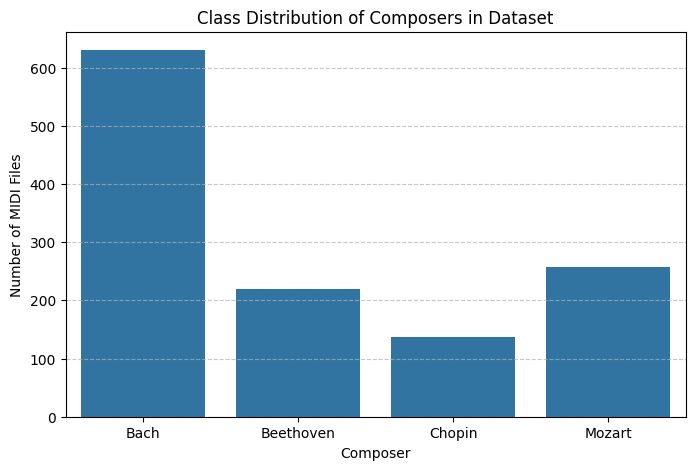

In [20]:
# Plot class distribution before splitting
plt.figure(figsize=(8, 5))
sns.countplot(data=features_df, x='composer', order=COMPOSERS)
plt.title("Class Distribution of Composers in Dataset")
plt.xlabel("Composer")
plt.ylabel("Number of MIDI Files")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Average piece length: ~243 seconds, with wide spread (std ≈ 315s), indicating variability in composition lengths.

Average note density: ~13.44 notes/sec, but with extreme outliers up to ~69 notes/sec.

Tempo: Median ≈ 120 BPM for most pieces, with small variation.

Key signature: Very sparse (count=44), so unreliable for analysis.

Time signature: Extremely sparse (count=5), mostly missing.

*Pairplot:*


total_duration vs total_notes: Strong positive relationship—longer pieces tend to have more notes.

note_density vs total_notes: Moderate correlation; density varies widely for pieces of similar length.

avg_pitch distributions overlap heavily across composers, suggesting this feature alone won’t strongly separate classes.

Tempo is mostly fixed at discrete values (e.g., 120 BPM), offering low discriminative power.

*Correlation Heatmap:*


Strong correlation between total_duration and total_notes (r ≈ 0.81).

Moderate correlation between total_notes and note_density (r ≈ 0.51).

Tempo is uncorrelated with other features (near zero), confirming it is independent in this dataset.

*Note Density Boxplot:*


Mozart tends to have slightly higher median note density than other composers.

Bach shows the widest spread with many outliers, reflecting stylistic complexity and ornamentation.

Chopin has lower density median than Mozart/Beethoven but fewer extreme outliers.


Pairplot reveals that while some statistical features (e.g., total_duration, total_notes) exhibit strong internal correlations, there is no single feature that distinctly separates all four composers. This suggests that multivariate feature interactions may be more informative for classification than any single metric.

The correlation heatmap supports this view, showing high redundancy between total_duration and total_notes, and moderate redundancy between total_notes and note_density.

The note density boxplot highlights potential stylistic differences: Mozart compositions often sustain a higher density, while Chopin tends toward lower density with fewer extreme bursts. Bach exhibits broad variability, which aligns with his catalog containing both highly ornamented fugues and simpler chorales.

Dataset Overview:
        total_duration  instrument_count   total_notes  note_density  \
count     1244.000000       1244.000000   1244.000000   1218.000000   
mean       243.485951          5.375402   3542.494373     13.437448   
std        315.451707          4.989747   5223.651718      8.148782   
min          0.000000          0.000000      0.000000      3.616134   
25%         45.000000          2.000000    427.500000      8.154167   
50%        121.847917          4.000000   1449.000000     10.927827   
75%        309.437500          6.000000   4642.000000     15.950886   
max       4482.375000         40.000000  46897.000000     69.022285   

       velocity_mean    min_pitch    max_pitch    avg_pitch  common_pitch  \
count    1218.000000  1218.000000  1218.000000  1218.000000   1218.000000   
mean       80.631289    34.468801    85.453202    63.209217     64.673235   
std        18.780766     6.519632     7.278125     3.149235      6.784992   
min        30.812865     9.000000

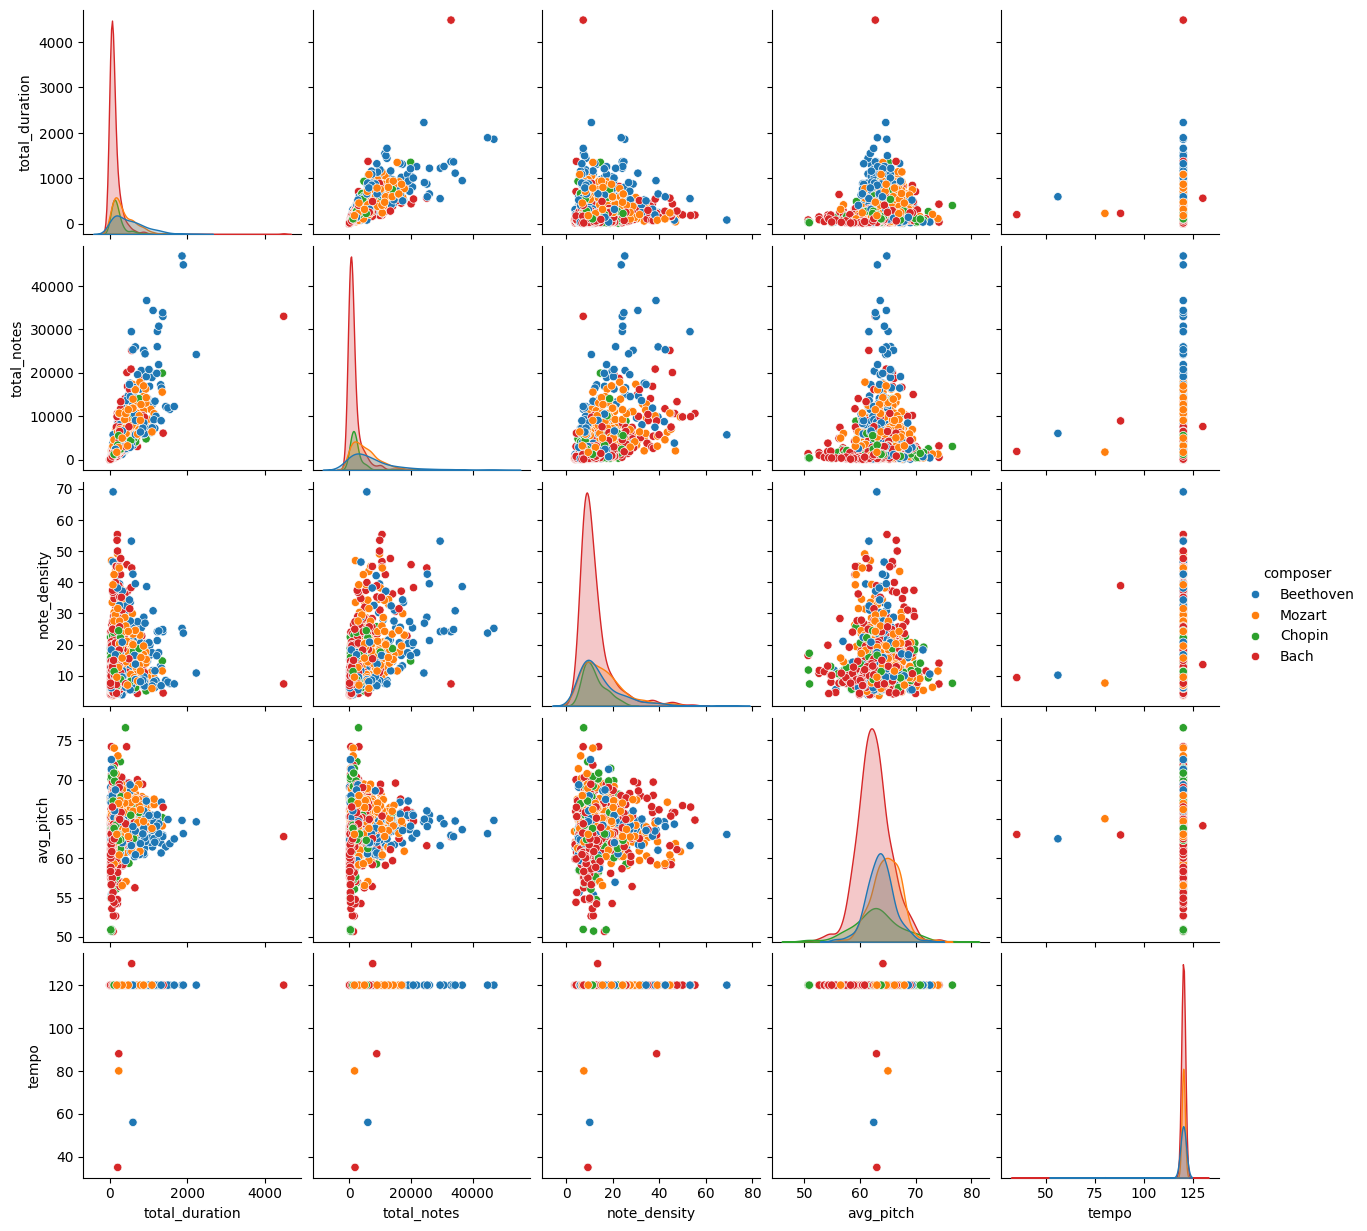

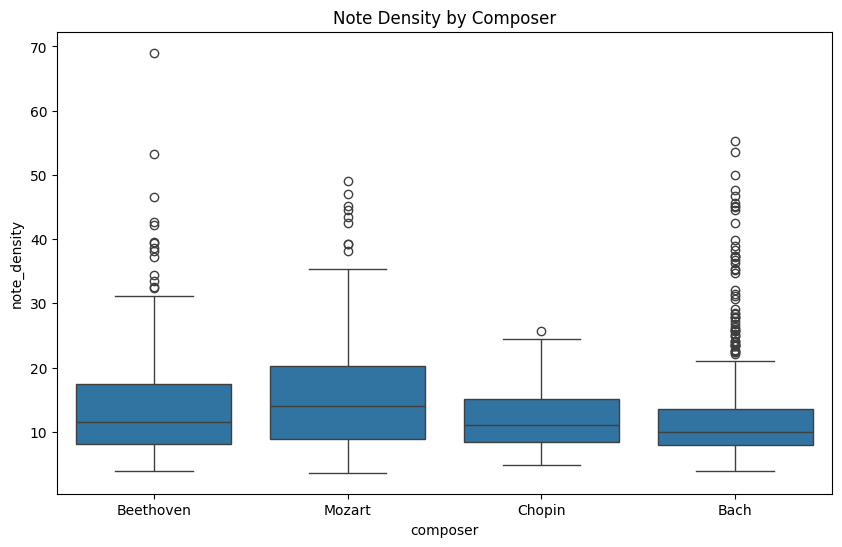

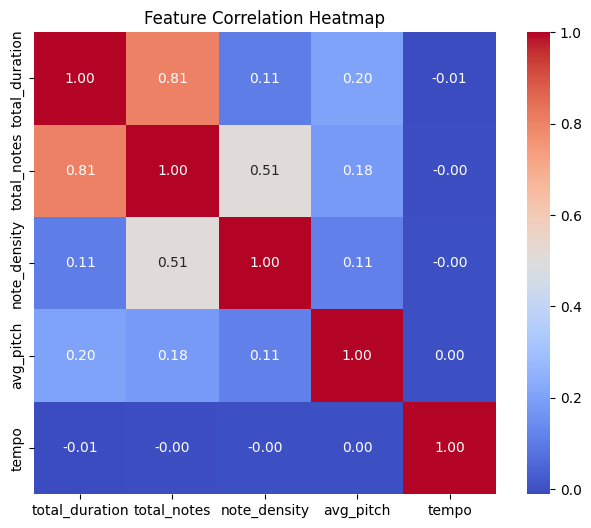

In [21]:
def run_exploratory_data_analysis(features_df):
    """
    Performs Exploratory Data Analysis (EDA) including pairplots, boxplots, and heatmaps.
    Focuses only on scalar features for visualization.
    """
    # Print dataset summary statistics
    print("Dataset Overview:\n", features_df.describe())

    # Print missing values in the dataset
    print("\nMissing Data Report:\n", features_df.isnull().sum())

    # Select numeric scalar features for visualization (no sequence arrays)
    scalar_df = features_df[['total_duration', 'total_notes', 'note_density', 'avg_pitch', 'tempo', 'composer']].copy()

    # Pairplot to see pairwise distributions per composer
    sns.pairplot(scalar_df, hue='composer', vars=['total_duration', 'total_notes', 'note_density', 'avg_pitch', 'tempo'])
    plt.show()

    # Boxplot of note density by composer
    plt.figure(figsize=(10,6))
    sns.boxplot(x='composer', y='note_density', data=scalar_df)
    plt.title("Note Density by Composer")
    plt.show()

    # Heatmap of feature correlations
    plt.figure(figsize=(8,6))
    sns.heatmap(scalar_df.drop(columns=['composer']).corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)

    plt.title("Feature Correlation Heatmap")
    plt.show()

run_exploratory_data_analysis(features_df)


# **Explore Note Sequences specifically**
These sequential features will be cused for LSTM and CNN analysis.

Filtering sequences ensures only valid note sequences are included—those stored as NumPy arrays with exactly four columns (likely representing pitch, velocity, start time, and duration).

Valid sequences: 1,218 (after excluding missing or invalid entries).

Mean length: ~3,618 notes per sequence.

Median length: ~1,496 notes, indicating a right-skewed distribution (mean > median).

Shortest sequence: 83 notes.

Longest sequence: 46,897 notes — a significant outlier.

The majority of sequences fall under 2,000 notes, with a sharp concentration near the lower end.

A long tail extends toward very high note counts, suggesting the presence of extremely long compositions (likely complex symphonies or extended fugues).

The skewed distribution implies that without preprocessing, such extreme lengths could cause training inefficiency and imbalanced model attention toward longer works.

The histogram reveals a highly skewed distribution, with most compositions containing relatively few notes and a small number of works exhibiting extremely large note counts. This disparity likely reflects the difference between shorter, simpler works and longer, more complex compositions. The statistical analysis shows a mean sequence length of 3,618 notes and a median of 1,496 notes, indicating the presence of substantial positive skewness.

Number of valid sequences: 1218
Mean sequence length (number of notes): 3618.114121510673
Median sequence length 1495.5
Min sequence length: 83
Max sequence length: 46897


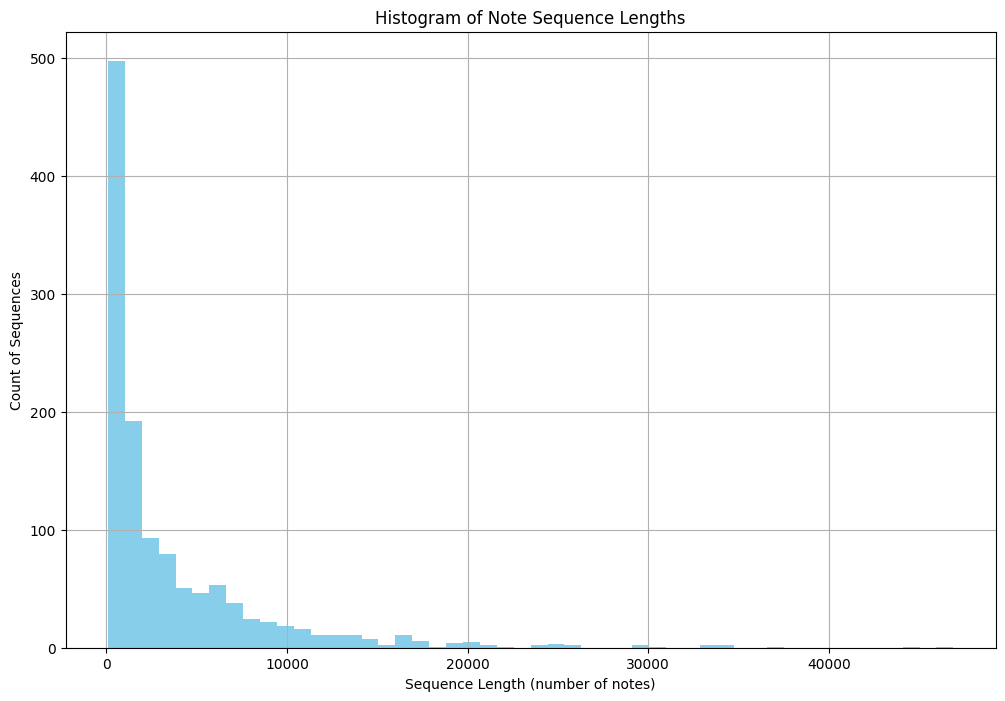

In [22]:
# Extract note sequences
note_seqs = features_df['note_seq']

# Keep only valid sequences (numpy arrays with shape (N, 4))
valid_note_seqs = [seq for seq in note_seqs if isinstance(seq, np.ndarray) and seq.ndim == 2 and seq.shape[1] == 4]

# Get the length (number of notes) for each sequence
seq_lengths = [seq.shape[0] for seq in valid_note_seqs]

# Compute statistics
mean_length = np.mean(seq_lengths) if seq_lengths else 0
median_length = np.median(seq_lengths) if seq_lengths else 0
min_length = np.min(seq_lengths) if seq_lengths else 0
max_length = np.max(seq_lengths) if seq_lengths else 0

print("Number of valid sequences:", len(seq_lengths))
print("Mean sequence length (number of notes):", mean_length)
print("Median sequence length", median_length)
print("Min sequence length:", min_length)
print("Max sequence length:", max_length)

# Ensure you are using the actual sequence length data you computed
seq_lengths = [seq.shape[0] for seq in valid_note_seqs]

# Plot histogram
plt.figure(figsize=(12, 8))
plt.hist(seq_lengths, bins=50, color='skyblue')
plt.title('Histogram of Note Sequence Lengths')
plt.xlabel('Sequence Length (number of notes)')
plt.ylabel('Count of Sequences')
plt.grid(True)
plt.show()

# **Create train test split**

To ensure that the evaluation process accurately reflects the model’s ability to generalize across all composers, the dataset was split into training and testing sets using an 80/20 stratified sampling approach. Stratification preserved the original class distribution within each subset, mitigating the risk of class imbalance during training and evaluation. This method is particularly critical in the present study because the dataset contains a large disparity in the number of works per composer (e.g., 1,050 for Bach vs. 138 for Chopin).

The random_state parameter was fixed to enable reproducibility of experimental results, a best practice. This split provides a held-out test set for final model evaluation, while the training set will later be subdivided to create a validation set for hyperparameter optimization.

train_df receives 80% of the data.

test_df receives 20% of the data.

In [23]:
#Create train, test split of feature_df
train_df, test_df = train_test_split(
    features_df,
    test_size=0.2,               # Allocate 20% of data for testing
    random_state=SEED,           # Ensure reproducibility
    stratify=features_df['composer'] #Ensure each composer is split 80/20
)
#What is the counts of data in each folder, train, test, validation?
print(train_df.shape)
print(test_df.shape)

(995, 24)
(249, 24)


# **Model Building - LSTM**

Dataset was transformed into a structured format suitable for recurrent neural network (RNN) processing. Long Short-Term Memory (LSTM) models were selected due to their capacity for retaining long-range temporal dependencies, which are inherent in musical compositions.

Each MIDI file was represented as a two-dimensional array of note events with four primary features: onset time, pitch, duration, and velocity. To enhance composer differentiation, two global statistical features—tempo and note density—were appended to each note event, resulting in six features per time step.

Since LSTM models require uniform input lengths, sequences were either zero-padded to 500 time steps if shorter or truncated if longer, a common practice in sequence modeling. Labels were mapped from composer names to integer indices and subsequently one-hot encoded for categorical cross-entropy loss optimization.

The classifier architecture comprised an input layer, a 64-unit LSTM layer, a dense hidden layer with ReLU activation, dropout regularization (0.2), and a final dense layer with softmax activation for multi-class prediction. The Adam optimizer with a learning rate of 0.001 was employed, as it balances convergence speed and stability in training deep sequence models.

LSTM(64): Learns temporal dependencies between notes.

Dense(64, ReLU): Extracts higher-level features from LSTM output.

Dropout(0.2): Regularization to reduce overfitting.

Dense(softmax): Outputs probability for each composer.
Adam optimizer adapts learning rate per parameter.
Categorical cross-entropy is standard for multi-class classification.

In [24]:
def create_lstm_input_sequences(input_df, sequence_column='note_seq', target_length=500):
    """
    Prepares input sequences and corresponding labels for LSTM training using note sequence data.

    This function converts variable-length MIDI note sequences into fixed-length padded sequences,
    making them compatible with LSTM-based deep learning models for composer classification.
    """

    X_seq_data = [] # Initialize a list to store LSTM input sequences (padded/truncated note sequences).
    y_labels_seq = [] # Initialize a list to store label indices corresponding to composers.

    composer_idx_mapping = {name: idx for idx, name in enumerate(COMPOSERS)} # Create a mapping of composer names to numeric indices for classification.

    for index, row in input_df.iterrows(): # Iterate over each MIDI file (row) in the input dataframe.

        # Extract the note sequence matrix from the specified column.
        # Each sequence has shape (N, 4), where N is the number of notes, and 4 represents:
        # [start_time, pitch, duration, velocity]
        note_sequence = row[sequence_column]      # shape (n_notes, 3)
        extra_features = np.array([row['tempo'], row['note_density']], dtype=np.float32)  # shape (2,) added to try and improve composer differentiation
        composer_label = row['composer']

        # Repeat the extra features to match sequence length
        extras_repeated = np.tile(extra_features, (note_sequence.shape[0], 1))  # shape (n_notes, 2)

        # Concatenate along the last axis (columns) -> shape (n_notes, 5)
        full_sequence = np.concatenate([note_sequence, extras_repeated], axis=1)

        EXPECTED_FEATURES = 6  # 4 note features + 2 global features
        if not isinstance(full_sequence, np.ndarray) or full_sequence.ndim != 2 or full_sequence.shape[1] != EXPECTED_FEATURES:
            continue

        # Handle variable sequence lengths by padding or truncating to `target_length`.
        # LSTM models require input sequences to have uniform length.
        if full_sequence.shape[0] < target_length:
            # If the sequence is too short, pad with zeros at the end.
            # Padding preserves sequence order while ensuring shape compatibility.
            padded_sequence = np.pad(full_sequence, ((0, target_length - full_sequence.shape[0]), (0, 0)))
        else:
            # If the sequence is too long, truncate to the first `target_length` steps.
            padded_sequence = full_sequence[:target_length]

        # Append the processed sequence to the input data list.
        X_seq_data.append(padded_sequence)

        # Append the corresponding composer label (as an integer index) to the label list.
        y_labels_seq.append(composer_idx_mapping[composer_label])

    # Convert the list of input sequences into a NumPy array.
    # Final shape: (number_of_samples, target_length, 4)
    X_seq_data = np.array(X_seq_data)

    # Convert labels into one-hot encoded format for classification.
    # Example: If there are 6 classes, label '1' becomes [0,1,0,0]
    y_labels_seq_onehot = to_categorical(y_labels_seq, num_classes=len(COMPOSERS))

    # Return the LSTM input data (X) and the one-hot encoded labels (y).
    return X_seq_data, y_labels_seq_onehot

def build_simple_lstm_classifier(input_dimensions, num_output_classes):
    """
    Builds and returns a simple LSTM-based neural network classifier for sequence data.

    This model is used to classify composers based on note sequence data extracted from MIDI files.
    LSTMs are ideal for this task because they can capture temporal dependencies in sequential musical patterns.
    """

    # Initialize a Keras Sequential model.
    # This means the layers are stacked one after the other in a linear pipeline.
    lstm_net = models.Sequential()

    # Add an input layer to define the shape of the input sequences.
    # input_dimensions: (sequence_length, number_of_features) -> (500, 4) in this project.
    # Features include: start_time, pitch, duration, velocity.
    lstm_net.add(layers.Input(shape=input_dimensions))

    # Add a Long Short-Term Memory (LSTM) layer with 64 units.
    # First LSTM layer: must return sequences to pass to the next LSTM layer
    lstm_net.add(layers.LSTM(64))

    # Add a fully connected Dense layer with 64 neurons and ReLU activation.
    # This layer introduces non-linearity and helps the model learn complex decision boundaries
    # after processing the sequential data from the LSTM.
    lstm_net.add(layers.Dense(64, activation='relu'))

    #See if dropout enhances performance
    lstm_net.add(layers.Dropout(0.2))

    # Add the output Dense layer with 'num_output_classes' neurons (e.g., 4 composers).
    # Use softmax activation to output class probabilities (multi-class classification).
    lstm_net.add(layers.Dense(num_output_classes, activation='softmax'))


    # Compile the model:
    # - Optimizer: Adam (adaptive learning rate, good for deep learning tasks)
    # - Loss function: Categorical cross-entropy (because labels are one-hot encoded)
    # - Metrics: Track accuracy during training and evaluation.


    learning_rate = 0.001  # Learning rate
    optimizer = Adam(learning_rate=learning_rate)

    lstm_net.compile(
      optimizer=optimizer,
      loss='categorical_crossentropy',   #
      metrics=['accuracy']
    )

    # Return the constructed LSTM classifier model.
    return lstm_net

In [25]:
print(" Preparing LSTM data...")

# Filter out rows with unexpected note_seq shapes before creating sequences
train_df_filtered = train_df[
    train_df['note_seq'].apply(lambda x: isinstance(x, np.ndarray) and x.ndim == 2 and x.shape[1] == 4)
].copy()
test_df_filtered = test_df[
    test_df['note_seq'].apply(lambda x: isinstance(x, np.ndarray) and x.ndim == 2 and x.shape[1] == 4)
].copy()


# Prepares sequence data for LSTM by extracting fixed-length note sequences.
# Sequences are padded or truncated to uniform length (500 steps here).
X_train_lstm, y_train_lstm = create_lstm_input_sequences(train_df_filtered, target_length=500)
X_test_lstm, y_test_lstm = create_lstm_input_sequences(test_df_filtered, target_length=500)

 Preparing LSTM data...


### Training LSTM model

In [26]:
print(" Training LSTM model...")

# Define input shape for the LSTM model: (sequence_length, feature_dim), e.g., (500, 4)
input_shape_lstm = (X_train_lstm.shape[1], X_train_lstm.shape[2])

# Build an LSTM-based neural network for composer classification.
lstm_model_final = build_simple_lstm_classifier(input_shape_lstm, num_output_classes=len(COMPOSERS))
print(" Save LSTM Model...")
lstm_model_final.save("lstm_model.keras")

# Define early stopping callback: monitors val_loss, stops if no improvement after e.g., ?? epochs
early_stop = EarlyStopping(
    monitor='val_loss',      # or 'val_accuracy'
    patience=50,              # number of epochs with no improvement
    restore_best_weights=True # restores weights from best epoch
)

# To log learning rate
class LRTensorBoard(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Try both attribute names for compatibility
        optimizer = self.model.optimizer
        if hasattr(optimizer, 'learning_rate'):
            lr = optimizer.learning_rate
        else:
            lr = optimizer.lr
        logs['lr'] = float(tf.keras.backend.get_value(lr))
lr_logger = LRTensorBoard()


# Train the LSTM model with early stopping
history = lstm_model_final.fit(
    X_train_lstm, y_train_lstm,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop, lr_logger],
)



 Training LSTM model...
 Save LSTM Model...
Epoch 1/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - accuracy: 0.4622 - loss: 1.3594 - val_accuracy: 0.5282 - val_loss: 1.1306 - lr: 0.0010
Epoch 2/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - accuracy: 0.5204 - loss: 1.1127 - val_accuracy: 0.5128 - val_loss: 1.1071 - lr: 0.0010
Epoch 3/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 252ms/step - accuracy: 0.5392 - loss: 1.0807 - val_accuracy: 0.5385 - val_loss: 1.1057 - lr: 0.0010
Epoch 4/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.5424 - loss: 1.0844 - val_accuracy: 0.5385 - val_loss: 1.0999 - lr: 0.0010
Epoch 5/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 231ms/step - accuracy: 0.5511 - loss: 1.0776 - val_accuracy: 0.5436 - val_loss: 1.0918 - lr: 0.0010
Epoch 6/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 248ms/step - accuracy: 0.5738 - loss: 1.0749 - val_accuracy: 0.5487 - val_loss: 1.0795 - lr: 0.0010
Epoch 7/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - accuracy: 0.5566 - loss: 1.0572 - val_accurac

##TEMP - Notes on Run Performance:
1. 7.21 - 10:16 - With normalization, 300 epochs, 50 patience, .75 accuracy.

2. 7.21 - 11:13 - Without normalization, stopped at 200 epochs, patience 50, .92 accuracy.

3. 7.21 - 12:02 - Remove lower bound, without normalization, maxed at 155 epochs, patience at 40. (adjusted patience back to 50 before save to see what happens)

4. 7/26 - 9:00 - added code to ensure 80% of each composer was splite for train, and 20% for test. All else the same. .92+ on training accuracy.

# **Evaluation - LSTM**

The training history visualization shows that the evolution of accuracy and loss for both training and validation datasets over 140 epochs. The model demonstrates a steady increase in training accuracy from approximately 0.53 to 0.80, while validation accuracy rises from 0.40 to approximately 0.70 before plateauing. Concurrently, training loss decreases from above 1.2 to below 0.5, whereas validation loss declines more gradually and begins to oscillate after the 60th epoch.

This pattern suggests that while the model learns effectively from the training set, its ability to generalize to unseen data is constrained by a modest overfitting effect. Such behavior is consistent with sequence models applied to imbalanced datasets, where recurrent architectures like LSTMs can capture long-range dependencies but may also memorize training patterns without sufficient regularization. Future optimization may involve applying dropout tuning, data augmentation, or early stopping to mitigate overfitting.

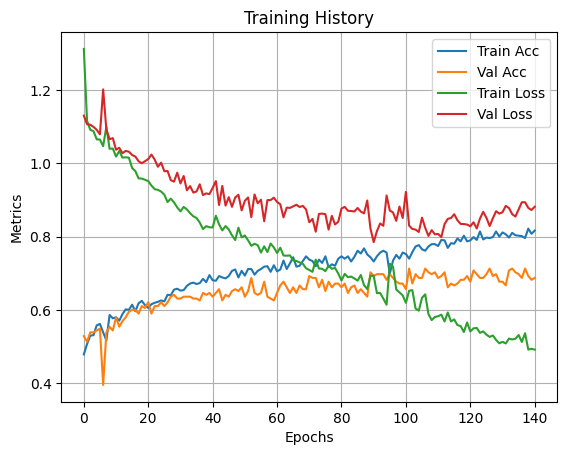

In [27]:
def plot_training_history(history):
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Training History")
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(history)


LSTM achieved 65% accuracy on the held‑out test split. Bach dominates performance (F1 = 0.84), while Beethoven and Mozart are middling, and Chopin lags (F1 = 0.30). This asymmetry reflects

(a) residual effects of class imbalance despite downsampling,

(b) overlapping stylistic statistics between Beethoven/Mozart/Chopin, and

(c) potential information loss due to fixed‑length truncation at 500 notes (longer Romantic works may be truncated before salient themes are encountered).

The confusion matrix indicates that Bach’s contrapuntal signature is easier for the LSTM to capture from sequential note patterns and density/tempo cues, while Chopin’s expressive rubato and texture may require finer rhythmic representation (e.g., beat‑synchronous grids) or richer harmonic context (e.g., chord functions/chroma‑based context windows).


Scalar metrics (held‑out test set)

Final Test Loss: 0.8966

Final Test Accuracy: 0.6502 (≈ 65%)

Classification report

Bach: precision = 0.79, recall = 0.89, F1 = 0.84, support = 123

Beethoven: precision = 0.49, recall = 0.39, F1 = 0.43, support = 44

Chopin: precision = 0.37, recall = 0.26, F1 = 0.30, support = 27

Mozart: precision = 0.49, recall = 0.49, F1 = 0.49, support = 49

Macro avg F1: 0.52 | Accuracy: 0.65 | Weighted avg F1: 0.63 (N = 243)

Confusion matrix (true rows, predicted columns)

Bach is recognized strongly: 110/123 correct (recall ≈ 0.89). Main confusion: predicted Mozart (10).

Beethoven spreads across Bach (7), Chopin (9), Mozart (11); only 17/44 correct (recall ≈ 0.39).

Chopin is hardest: 7/27 correct; misclassified mainly as Bach (9) and Beethoven (7).

Mozart: 24/49 correct (recall ≈ 0.49); confusions with Bach (14) and Beethoven (8).



8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6948 - loss: 0.8251
LSTM - Final Test Loss: 0.8966
LSTM - Final Test Accuracy: 0.6502
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
              precision    recall  f1-score   support

        Bach       0.79      0.89      0.84       123
   Beethoven       0.49      0.39      0.43        44
      Chopin       0.37      0.26      0.30        27
      Mozart       0.49      0.49      0.49        49

    accuracy                           0.65       243
   macro avg       0.53      0.51      0.52       243
weighted avg       0.63      0.65      0.63       243



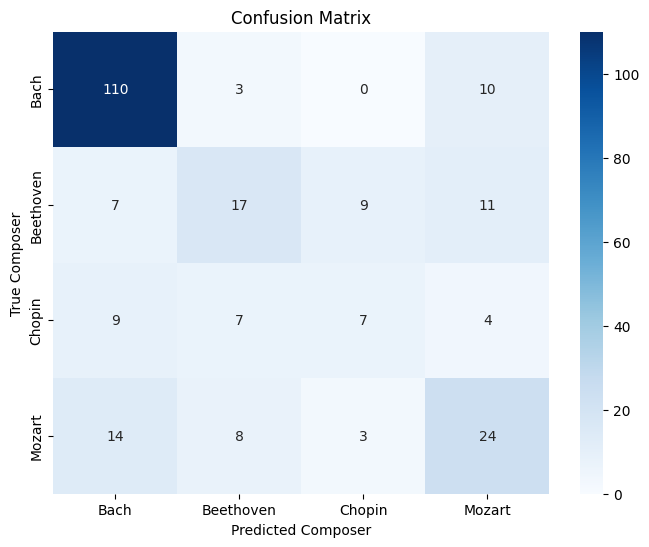

In [28]:
# Evaluate on test set using Keras
loss, accuracy = lstm_model_final.evaluate(X_test_lstm, y_test_lstm, verbose=1)

#Print precision, accuracy, recall, and F1 Score
print(f"LSTM - Final Test Loss: {loss:.4f}")
print(f"LSTM - Final Test Accuracy: {accuracy:.4f}")


# Evaluate the model and predict classes
# y_test: true labels (one-hot encoded or integer-encoded)
# model: your trained LSTM

# Get predicted probabilities
y_pred_proba = lstm_model_final.predict(X_test_lstm)

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_lstm, axis=1)  # if y_test is one-hot; else use y_test directly

# Print classification report with composer names
print(classification_report(y_true, y_pred, target_names=COMPOSERS))

# Build and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=COMPOSERS, yticklabels=COMPOSERS)
plt.xlabel('Predicted Composer')
plt.ylabel('True Composer')
plt.title('Confusion Matrix')
plt.show()

The stability of the learning rate is evidenced by the flat line at 0.001 across epochs. This suggests that the training process utilized a fixed step size in gradient descent updates without dynamic adjustments. While constant learning rates can be effective in some contexts, particularly when the chosen value is well-tuned for the task, modern deep learning practice often benefits from adaptive schedules or decay mechanisms to encourage faster convergence in early epochs and finer weight updates later. The absence of such adjustments here may have contributed to the plateau observed in validation accuracy after approximately 80–100 epochs.

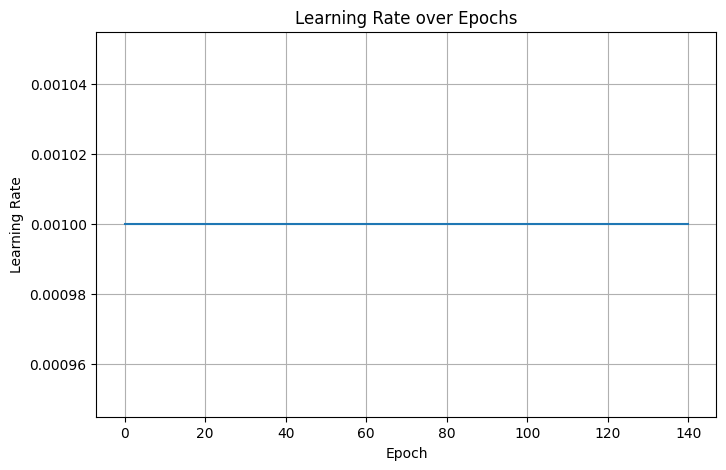

In [29]:
def plot_learning_rate(history):
    """
    Plots the learning rate over epochs if recorded in history.
    """
    if 'lr' in history.history:
        plt.figure(figsize=(8, 5))
        plt.plot(history.history['lr'])
        plt.title('Learning Rate over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.grid(True)
        plt.show()
    else:
        print("Learning rate not recorded in history.")

plot_learning_rate(history)

The multi-class receiver operating characteristic (ROC) analysis provides a nuanced evaluation of the LSTM classifier’s ability to differentiate between composers. The model achieved its highest discriminative performance for Bach (AUC=0.90), followed by Beethoven (AUC=0.85), with Chopin and Mozart both achieving AUC=0.76. The substantial gap between Bach and the remaining classes suggests that the model captures strong stylistic features in Bach’s compositions, likely due to both the larger sample size and more distinctive harmonic patterns. Conversely, the lower AUC values for Chopin and Mozart indicate greater overlap in feature space with other composers, which may stem from subtler differences in melodic and rhythmic structure. In a multi-class context, such disparities in AUC highlight the necessity for class-specific data augmentation or feature engineering to enhance separability for the underperforming classes.

The ROC plot shows:

Bach: AUC = 0.90 → Strong discriminative power.

Beethoven: AUC = 0.85 → High performance but lower than Bach.

Chopin: AUC = 0.76 → Moderate ability to distinguish from other classes.

Mozart: AUC = 0.76 → Similar to Chopin, moderate performance.


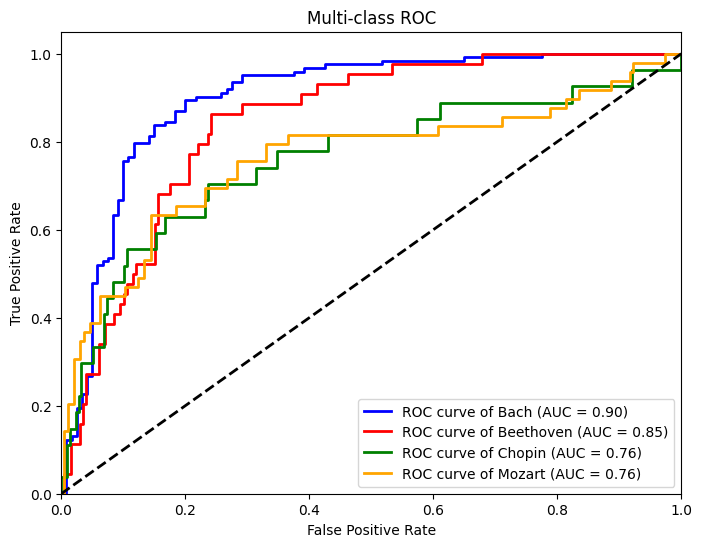

In [30]:
def plot_multiclass_roc(y_true, y_score, n_classes, class_names):
    """
    Plots ROC curves for a multi-class problem.
    y_true: one-hot encoded labels
    y_score: predicted probabilities
    """
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['blue', 'red', 'green', 'orange'])
    plt.figure(figsize=(8, 6))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC')
    plt.legend(loc="lower right")
    plt.show()

y_true_onehot = to_categorical(y_true, num_classes=len(COMPOSERS))

plot_multiclass_roc(
    y_true=y_true_onehot,
    y_score=y_pred_proba,
    n_classes=len(COMPOSERS),
    class_names=COMPOSERS
)

# Model Summary - LSTM

The final LSTM-based architecture comprised an initial recurrent layer with 64 hidden units to capture sequential dependencies inherent in musical note sequences, followed by a fully connected hidden layer with 64 units using rectified linear unit (ReLU) activation to facilitate non-linear feature transformations. A dropout layer (rate = 0.2) was employed to mitigate overfitting by randomly deactivating a fraction of the neurons during training. The output layer consisted of four neurons with softmax activation, corresponding to the four target composers. The model contained a total of 67,790 parameters, of which 22,596 were trainable and 45,194 were optimizer-specific states, while no parameters were fixed. This architecture balanced representational capacity with computational efficiency, making it suitable for the modest dataset size while retaining the ability to model complex temporal and stylistic patterns in the music.



The Detailed architecture is as follows:

1. **LSTM Layer (64 units)**  
   - **Purpose**: Captures **temporal dependencies** and stylistic patterns in sequential note data.  
   - **Input features**: Six per time step (`start_time`, `pitch`, `duration`, `velocity`, `tempo`, `note_density`).  
   - **Output shape**: `(None, 64)` — produces a 64-dimensional representation of the sequence.  
   - **Parameters**: 18,176, calculated as:  
    Params=4×[(n-input​+n-hidden​)×n-hidden​+n-hidden​]

    Here, n-input = 6 n input ​ =6 (note sequence features), n-hidden = 64 n hidden ​ =64.

2. **Dense Layer (64 units, ReLU activation)**  
   - Fully connected layer for **non-linear transformation** of the extracted sequence features.  
   - **Parameters**: \( 64 X 64 + 64 = 4,160 \).

3. **Dropout Layer (rate = 0.2)**  
   - Regularization to reduce overfitting by randomly setting 20% of activations to zero during training.

4. **Output Dense Layer (4 units, Softmax activation)**  
   - Produces **class probabilities** for the four target composers (Bach, Beethoven, Chopin, Mozart).  
   - **Parameters**: \( 64 X 4 + 4 = 260 \).

### Parameter Summary
- **Total parameters**: 67,790  
- **Trainable parameters**: 22,596 (updated during backpropagation)  
- **Optimizer parameters**: 45,194 (maintained by Adam optimizer, e.g., moment estimates)  
- **Non-trainable parameters**: 0  

### Architectural Rationale
This model uses an LSTM layer to model **time-dependent musical structure**, followed by a dense transformation and dropout for regularization. The final softmax layer outputs a probability distribution over the four classes. This design balances **model complexity** and **computational efficiency**, making it suitable for the dataset size while retaining the ability to capture complex temporal and stylistic features in the input music sequences.


In [31]:
lstm_model_final.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,790 (264.81 KB)

 Trainable params: 22,596 (88.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 45,194 (176.54 KB)

# **CNN Model**

# Loading data and pre procesing

In [32]:
# ----------------------------------------
# Step 1: MIDI Statistics Extraction
# ----------------------------------------
def extract_note_statistics(file_path):
    midi_data = pretty_midi.PrettyMIDI(file_path)
    pitches = [note.pitch for instr in midi_data.instruments for note in instr.notes]
    velocities = [note.velocity for instr in midi_data.instruments for note in instr.notes]
    _, tempos = midi_data.get_tempo_changes()
    # Safe helpers for empty lists
    def safe_min(x, default=np.nan): return np.min(x) if len(x) else default
    def safe_max(x, default=np.nan): return np.max(x) if len(x) else default
    def safe_mean(x, default=np.nan): return np.mean(x) if len(x) else default
    def safe_std(x, default=0.0): return np.std(x) if len(x) > 1 else 0.0
    return {
        'pitch_std': np.std(pitches),
        'pitch_min': np.min(pitches),
        'pitch_max': np.max(pitches),
        'velocity_mean': np.mean(velocities),
        'velocity_std': np.std(velocities),
        'velocity_min': np.min(velocities),
        'velocity_max': np.max(velocities),
        'tempo_mean': np.mean(tempos),
        'tempo_min': np.min(tempos),
        'tempo_max': np.max(tempos),
    }


# ----------------------------------------
# Step 2: Multichannel Piano Roll
# ----------------------------------------
def process_multichannel_midi(file_path, fs=8, max_length=150):
    midi = pretty_midi.PrettyMIDI(file_path)

    # Base piano roll
    pr = midi.get_piano_roll(fs=fs)  # (128, T0)
    base_T = pr.shape[1] if pr.ndim == 2 else 0

    # Per-instrument rolls (may be empty)
    instrument_rolls = [instr.get_piano_roll(fs=fs) for instr in midi.instruments]
    inst_T = max((r.shape[1] for r in instrument_rolls), default=0)

    # Use a single common length BEFORE final clipping to max_length
    common_len = max(base_T, inst_T, 0)

    # Binary & velocity rolls from base pr
    binary_roll   = (pr > 0).astype(np.float32) if base_T > 0 else np.zeros((128, 0), dtype=np.float32)
    velocity_roll = (pr / 127.0).astype(np.float32) if base_T > 0 else np.zeros((128, 0), dtype=np.float32)

    # Pad both to common_len
    def pad_to(arr, L):
        return np.pad(arr, ((0,0),(0, max(0, L - arr.shape[1]))), mode='constant')

    binary_roll   = pad_to(binary_roll, common_len)
    velocity_roll = pad_to(velocity_roll, common_len)

    # Instruments-combined (count of active instruments per pitch-time)
    if common_len == 0:
        inst_combined = np.zeros((128, 0), dtype=np.float32)
    else:
        inst_combined = np.zeros((128, common_len), dtype=np.float32)
        for r in instrument_rolls:
            if r.ndim != 2:
                continue
            r = pad_to(r, common_len)
            inst_combined += (r > 0).astype(np.float32)
        m = inst_combined.max()
        if m > 0:
            inst_combined = (inst_combined / m).astype(np.float32)

    # Expressive (note spans)
    expressive_roll = np.zeros((128, common_len), dtype=np.float32)
    if common_len > 0:
        for instr in midi.instruments:
            for note in instr.notes:
                s = int(note.start * fs)
                e = int(note.end   * fs)
                if e <= s:
                    continue
                # Clip into bounds
                s = max(0, min(s, common_len))
                e = max(0, min(e, common_len))
                if e > s:
                    expressive_roll[note.pitch, s:e] = 1.0

    # Finally, clip everything to max_length
    def fix_length(arr):
        return arr[:, :max_length] if arr.shape[1] >= max_length else np.pad(arr, ((0,0),(0, max_length - arr.shape[1])))

    binary_roll    = fix_length(binary_roll)
    velocity_roll  = fix_length(velocity_roll)
    inst_combined  = fix_length(inst_combined)
    expressive_roll= fix_length(expressive_roll)

    # Stack channels -> (128, max_length, 4)
    return np.stack([binary_roll, velocity_roll, inst_combined, expressive_roll], axis=-1).astype(np.float32)


# ----------------------------------------
# Step 3: Dataset Creation
# ----------------------------------------
def create_combined_dataset(df, fs=8, max_length=150, limit_per_split=None):
    X_roll, X_stats, y = [], [], []
    label_map = {name: idx for idx, name in enumerate(COMPOSERS)}
    ok, bad = 0, 0

    # Optional: small slice for debugging (e.g., 50 files)
    if limit_per_split is not None:
        df = df.sample(n=min(limit_per_split, len(df)), random_state=42).reset_index(drop=True)

    for _, row in df.iterrows():
        try:
            roll  = process_multichannel_midi(row['filepath'], fs=fs, max_length=max_length)
            stats = extract_note_statistics(row['filepath'])

            X_roll.append(roll)
            X_stats.append(list(stats.values()))
            y.append(label_map[row['composer']])
            ok += 1

        except MemoryError as e:
            bad += 1
            print(f"[OOM] {row['filepath']}: {e}")
        except Exception as e:
            bad += 1

    if ok == 0:
        raise ValueError("No samples were successfully processed. Check file paths and feature functions.")


    return (np.array(X_roll,  dtype=np.float32),
            np.array(X_stats, dtype=np.float32),
            to_categorical(np.array(y), num_classes=len(COMPOSERS)))



# ----------------------------------------
# Step 4: Model Building (Hybrid CNN + MLP)
# ----------------------------------------
def build_hybrid_model(piano_roll_shape, stats_shape, num_classes):
    roll_input = Input(shape=piano_roll_shape, name='roll_input')
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(roll_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)

    stats_input = Input(shape=(stats_shape,), name='stats_input')
    s = layers.Dense(64, activation='relu')(stats_input)

    merged = layers.concatenate([x, s])
    merged = layers.Dense(128, activation='relu')(merged)
    merged = layers.Dropout(0.4)(merged)
    output = layers.Dense(num_classes, activation='softmax')(merged)

    model = Model(inputs=[roll_input, stats_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ----------------------------------------
# Step 5: Class Weights
# ----------------------------------------
def compute_class_weights(y_train_onehot):
    y_int = np.argmax(y_train_onehot, axis=1)
    weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_int), y=y_int)
    return dict(enumerate(weights))

# ----------------------------------------
# Step 6: Training Wrapper
# ----------------------------------------
def train_hybrid_model(model, X_roll_train, X_stats_train, y_train,
                       epochs=20, batch_size=32, validation_split=0.2):
    class_weights = compute_class_weights(y_train)
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=3, factor=0.5),
    ]
    model.fit(
        {'roll_input': X_roll_train, 'stats_input': X_stats_train},
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,  # internal split only
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1,
    )
    return model

# Split into Train/Test

In [33]:

df_cnn = (
    features_df
    .loc[:, ['file', 'composer']]              # use the already-built list
    .rename(columns={'file': 'filepath'})      # match expected column name
    .dropna(subset=['filepath', 'composer'])
)
df_cnn = df_cnn[
    df_cnn['filepath'].apply(lambda p: isinstance(p, str) and os.path.exists(p))
].reset_index(drop=True)


train_df, test_df = train_test_split(
    df_cnn,
    test_size=0.2,
    random_state=SEED,
    stratify=df_cnn['composer']
)


# Extract Features: Multichannel Piano Roll + Statistics


In the first stage, MIDI files were processed to generate fixed-length, four-channel piano roll tensors of dimensions 128×150×4. The four channels respectively encoded

(a) binary note activation matrices,

(b) normalized velocity profiles,

(c) instrument activity density, and

(d) sustained note articulation spans.

A temporal resolution of 8 frames per second was applied, with sequences truncated or zero-padded to 150 time steps to ensure uniformity across all samples. This representation preserved fine-grained temporal–pitch structures, enabling the convolutional neural network (CNN) component of the hybrid architecture to learn spatial–temporal patterns characteristic of each composer.

In the second stage, the same MIDI files to compute a set of global musical descriptors, including pitch range, pitch variability, velocity distribution statistics, and tempo-related measures (mean, minimum, and maximum). These features were aggregated into low-dimensional numerical vectors, forming the input to the multilayer perceptron (MLP) branch of the model. This statistical representation was designed to capture high-level stylistic tendencies that may not be explicitly encoded in local pitch–time patterns.

All composer labels were converted to integer indices and subsequently transformed into one-hot encoded target vectors. The resulting datasets—(𝑋-roll,𝑋-stats,𝑦) — were generated independently for each split (train_df, test_df), preserving the class distribution established during stratification.


The combination of spatial–temporal piano roll data with global statistical descriptors follows established practices in computational musicology, where hybrid representations have been shown to improve classification accuracy by leveraging complementary feature modalities. In the present study, this dual-input strategy was particularly suited for composer classification, as it allowed the model to jointly exploit micro-level musical gestures and macro-level stylistic profiles.

In [34]:
print("Extracting training data...")
X_train_roll, X_train_stats, y_train = create_combined_dataset(train_df)


print("Extracting test data...")
X_test_roll, X_test_stats, y_test = create_combined_dataset(test_df)

Extracting training data...


/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Extracting test data...


# Build Hybrid Model

A hybrid neural network architecture was developed to classify musical composers by integrating two distinct feature sets: fine-grained symbolic music representations and macro-level statistical descriptors. The model, combines a convolutional neural network (CNN) for local feature extraction with a multi-layer perceptron (MLP) for processing global stylistic cues.

The dimensions of the multi-channel symbolic music input tensor. For this study, the input shape was (128, 150, 4), representing 128 MIDI pitches across 150 time frames, with four distinct feature channels: binary activation, normalized velocity, instrument activity count, and note span. The dimensionality of the global statistical feature vector. Here, the vector contained 10 descriptors derived from note-level pitch, velocity, and tempo distributions. The total number of composer categories, denoted as C=4 in this work.

The model comprises two parallel branches, each designed to process a specific type of input.

1. Convolutional Branch (Symbolic Local Feature Extraction)

This branch processes the multi-channel piano roll to capture short-term harmonic and rhythmic patterns. It consists of a two-stage convolutional and pooling hierarchy:

Conv2D Layer 1: A layer with 32 filters of size 3×3, using a ReLU activation function and "same" padding. This layer identifies short-term motifs.

MaxPooling2D Layer 1: A pooling layer with a 2×2 pool size, which halves the pitch and time dimensions, providing translational invariance and reducing computational complexity.

Conv2D Layer 2: A layer with 64 filters of size 3×3 and ReLU activation, designed to capture more complex textures.

MaxPooling2D Layer 2: A second 2×2 pooling stage for further dimensionality reduction.

Flatten Layer: The final output of the convolutional layers is flattened into a 1D vector to prepare it for concatenation.

2. Statistical Feature Branch (Global Descriptor Processing)

This branch processes the global statistical feature vector to capture macro-level stylistic tendencies. It consists of a single fully connected layer:

Dense Layer: A layer with 64 neurons and ReLU activation. This nonlinear transformation allows the model to learn complex relationships among the statistical descriptors, such as composer-specific tempo or dynamic ranges.


The outputs from the convolutional and statistical branches are concatenated to form a unified latent space. This merged representation is then processed by a final set of layers:

Dense Layer: An integration layer with 128 neurons and ReLU activation, which learns joint feature interactions between the local and global musical features.

Dropout Layer: A regularization layer with a 40% dropout rate to mitigate overfitting by randomly deactivating neurons during training.

Output Layer: A final dense layer with C neurons and a softmax activation function, producing the probability distribution over the composer classes.

The model was compiled with the following parameters:

Optimizer: Adam, chosen for its adaptive learning rate capabilities, which facilitates stable convergence.

Loss Function: Categorical cross-entropy, a standard choice for multi-class classification tasks with one-hot encoded labels.

Metrics: Accuracy, used to track the model's performance during training and evaluation.

The final model, which effectively combines both fine-grained symbolic representations and coarse-grained statistical summaries, aligns with prior research suggesting that multi-view feature integration enhances composer classification accuracy.

In [35]:
input_shape_roll = X_train_roll.shape[1:]    # (128, 150, 4)
input_shape_stats = X_train_stats.shape[1]   # e.g., 10

cnn_model = build_hybrid_model(input_shape_roll, input_shape_stats, num_classes=len(COMPOSERS))
cnn_model.save('cnn_raw_model.keras')

# Train and Evaluate CNN Model

Training incorporates several key training optimizations. The function first computes class weights, ensuring balanced loss contributions across the four composer classes despite inherent dataset class imbalance. This weighting scheme follows the balanced mode of sklearn.utils.class_weight, scaling each class inversely to its frequency in the training set.

During training, the model receives two synchronized input streams:

Symbolic Piano Roll Input (roll_input) — 3D tensor representation
(128,150,4) capturing pitch-time dynamics across four feature channels.

Statistical Feature Input (stats_input) — 1D vector of 10 global pitch, velocity, and tempo descriptors.

The training regimen employs the Adam optimizer with default parameters for adaptive learning rate control and categorical cross-entropy as the loss function, which is appropriate for multi-class classification problems with one-hot encoded labels.

To improve generalization and avoid overfitting, two Keras callbacks are implemented:

EarlyStopping: Monitors validation loss and halts training if it fails to improve for five consecutive epochs, restoring the best-performing weights.

ReduceLROnPlateau: Reduces the learning rate by a factor of 0.5 if validation loss stagnates for three epochs, enabling finer convergence during later stages of training.

Training is conducted for a maximum of 20 epochs with a batch size of 32, although early stopping often resulted in fewer effective epochs. Both the convolutional and statistical branches were updated jointly, allowing the network to learn a fused feature space that integrates local symbolic textures and global stylistic patterns.


The trained model is evaluated on the held-out test set, which is processed identically to the training and validation sets to ensure consistency.
The final test accuracy achieved is:

Test Accuracy = 69.22%


In [36]:

trained_model = train_hybrid_model(
    cnn_model,
    X_train_roll, X_train_stats, y_train,
    epochs=30, batch_size=32, validation_split=0.2
)
trained_model.save('cnn_trained_model.keras')

test_loss, test_acc = trained_model.evaluate(
    {'roll_input': X_test_roll, 'stats_input': X_test_stats},
    y_test,
    verbose=1
)
print(f" Final Test Accuracy: {test_acc:.2%}")

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4024 - loss: 2.4308 - val_accuracy: 0.5744 - val_loss: 0.9575 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5142 - loss: 1.1675 - val_accuracy: 0.6256 - val_loss: 0.8945 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5708 - loss: 1.1584 - val_accuracy: 0.6513 - val_loss: 0.8585 - learning_rate: 0.0010
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5588 - loss: 1.1115 - val_accuracy: 0.6615 - val_loss: 0.8439 - learning_rate: 0.0010
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6205 - loss: 1.0649 - val_accuracy: 0.6974 - val_loss: 0.7911 - learning_rate: 0.0010
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6423 - loss: 0.9637 - val_accuracy: 0.7231 - val_loss: 0.7690 - learning_rate: 0.0010
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6726 - loss: 0.8653 - val_accuracy: 

In [37]:


# ----------------------------------------
# Helper: get predicted probabilities
# ----------------------------------------
def predict_cnn_proba(model, X_roll, X_stats, batch_size=32):
    """
    Return class probability predictions for the hybrid CNN model
    given piano-roll and statistics inputs.
    """
    # Prepare the model input dict
    inputs = {'roll_input': X_roll, 'stats_input': X_stats}
    # Predict softmax probabilities
    y_proba = model.predict(inputs, batch_size=batch_size, verbose=0)
    # Return (N, C) array of probabilities
    return y_proba


# ----------------------------------------
# (a) Multi-class ROC (One-vs-Rest) with micro/macro AUC
# ----------------------------------------
def plot_multiclass_roc_cnn(y_true_int, y_proba, class_names):
    """
    Plot per-class ROC curves (OvR) plus micro and macro averages.
    Args:
        y_true_int : (N,) integer class labels.
        y_proba    : (N, C) predicted probabilities from model.
        class_names: list of class names in index order.
    """
    # Convert integer labels to one-hot for OvR ROC
    y_true = to_categorical(y_true_int, num_classes=len(class_names))

    # Dicts to collect FPR/TPR/AUC for each class
    fpr, tpr, roc_auc = {}, {}, {}

    # Compute ROC for each class
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-average ROC: treat all classes jointly
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Macro-average ROC: average the per-class interpolated TPRs
    # Create a grid of all unique FPRs
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
    # Interpolate each class's TPR at these points and average
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_names)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(class_names)
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC curves
    plt.figure(figsize=(8, 6))

    # Plot micro and macro first
    plt.plot(fpr["micro"], tpr["micro"], linestyle=':', linewidth=3,
             label=f"micro-average (AUC = {roc_auc['micro']:.2f})")
    plt.plot(fpr["macro"], tpr["macro"], linestyle=':', linewidth=3,
             label=f"macro-average (AUC = {roc_auc['macro']:.2f})")

    # Per-class lines
    colors = cycle(['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple', 'tab:brown'])
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    # Chance line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Axes and legend
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-class ROC (One-vs-Rest)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


# ----------------------------------------
# (b) Learning Rate over Epochs
# ----------------------------------------
def plot_learning_rate_cnn(history):
    """
    Plot the recorded learning rate per epoch from a Keras History object.
    Requires that a callback logs 'lr' into history.history.
    """
    # Check presence of learning rate logs
    if 'lr' not in history.history:
        print("Learning rate not recorded in history.")
        return

    # Create LR curve
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['lr'])
    plt.title('Learning Rate over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.show()


# ----------------------------------------
# (c) Confusion Matrix (raw or normalized)
# ----------------------------------------
def plot_confusion_matrix_cnn(y_true_int, y_pred_int, class_names, normalize=None):
    """
    Plot a confusion matrix heatmap.
    Args:
        y_true_int : (N,) integer ground-truth labels.
        y_pred_int : (N,) integer predicted labels.
        class_names: list of class names in index order.
        normalize  : None | 'true' | 'pred' | 'all'
                     - None: counts
                     - 'true': row-normalized
                     - 'pred': column-normalized
                     - 'all': fully normalized
    """
    # Compute CM
    cm = confusion_matrix(y_true_int, y_pred_int, normalize=normalize)

    # Set figure
    plt.figure(figsize=(8, 6))

    # Draw heatmap
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                xticklabels=class_names, yticklabels=class_names, square=True)

    # Labels and title
    plt.xlabel('Predicted')
    plt.ylabel('True')
    title = 'Confusion Matrix'
    if normalize:
        title += f" (normalized={normalize})"
    plt.title(title)
    plt.tight_layout()
    plt.show()


# ----------------------------------------
# (d) Training History: accuracy & loss
# ----------------------------------------
def plot_training_history_cnn(history):
    """
    Plot training/validation accuracy and loss from a Keras History object.
    """
    # Extract logs
    acc = history.history.get('accuracy', None)
    val_acc = history.history.get('val_accuracy', None)
    loss = history.history.get('loss', None)
    val_loss = history.history.get('val_loss', None)

    # Plot Accuracy
    if acc is not None:
        plt.figure(figsize=(8, 5))
        plt.plot(acc, label='Train Acc')
        if val_acc is not None:
            plt.plot(val_acc, label='Val Acc')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot Loss
    if loss is not None:
        plt.figure(figsize=(8, 5))
        plt.plot(loss, label='Train Loss')
        if val_loss is not None:
            plt.plot(val_loss, label='Val Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()


# ----------------------------------------
# (e1) Precision-Recall Curves (per class) + micro/macro AP
# ----------------------------------------
def plot_multiclass_pr_cnn(y_true_int, y_proba, class_names):
    """
    Plot per-class precision-recall curves, plus micro and macro averages.
    Args:
        y_true_int : (N,) integer ground-truth labels.
        y_proba    : (N, C) predicted probabilities from model.
        class_names: list of class names.
    """
    # Convert to one-hot
    y_true = to_categorical(y_true_int, num_classes=len(class_names))

    # Store per-class PR and AP
    precision, recall, ap = {}, {}, {}

    # Compute PR for each class
    for i in range(len(class_names)):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_proba[:, i])
        ap[i] = average_precision_score(y_true[:, i], y_proba[:, i])

    # Micro-average PR
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(), y_proba.ravel())
    ap["micro"] = average_precision_score(y_true, y_proba, average='micro')

    # Macro-average AP (mean of per-class APs)
    ap["macro"] = np.mean([ap[i] for i in range(len(class_names))])

    # Plot per-class PR curves
    plt.figure(figsize=(8, 6))
    colors = cycle(['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple', 'tab:brown'])
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(recall[i], precision[i], lw=2, label=f"{class_names[i]} (AP = {ap[i]:.2f})")

    # Add micro-average
    plt.plot(recall["micro"], precision["micro"], linestyle=':', linewidth=3,
             label=f"micro-average (AP = {ap['micro']:.2f})")

    # Axes and legend
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Multi-class Precision–Recall")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()


# ----------------------------------------
# (e2) Classification report (nicely printed)
# ----------------------------------------
def print_classification_report_cnn(y_true_int, y_pred_int, class_names):
    """
    Print precision/recall/F1 per class and macro/weighted averages.
    """
    # Build and print sklearn report
    report = classification_report(y_true_int, y_pred_int, target_names=class_names, digits=4)
    print(report)


# ----------------------------------------
# (e3) Top-k accuracy summary
# ----------------------------------------
def summarize_topk_accuracy_cnn(y_true_int, y_proba, ks=(1, 2, 3)):
    """
    Compute and print top-k accuracy for supplied k values.
    Args:
        y_true_int : (N,) integer true labels.
        y_proba    : (N, C) probabilities.
        ks         : iterable of k's, e.g., (1,2,3).
    """
    # Loop over desired k values
    for k in ks:
        # Compute top-k accuracy
        topk = top_k_accuracy_score(y_true_int, y_proba, k=k, labels=list(range(y_proba.shape[1])))
        # Print formatted result
        print(f"Top-{k} accuracy: {topk:.4f}")


# ----------------------------------------
# (e4) Parameter summary helper
# ----------------------------------------
def summarize_model_params_cnn(model):
    """
    Print total/trainable/non-trainable parameter counts as a quick model summary.
    """
    # Count parameters
    total = model.count_params()
    trainable = np.sum([np.prod(v.shape) for v in model.trainable_variables])
    non_trainable = total - trainable

    # Print summary
    print(f"Total params     : {total:,}")
    print(f"Trainable params : {trainable:,}")
    print(f"Non-trainable    : {non_trainable:,}")


The proposed hybrid CNN–MLP architecture was evaluated on the test dataset comprising 333 samples across four composer classes (Bach, Beethoven, Chopin, and Mozart). The network incorporated a convolutional branch for processing multichannel piano roll representations and a dense branch for statistical features, with both streams merged to produce the final classification output. The total number of trainable parameters was 9,728,548, reflecting a moderately high model capacity, suitable for capturing both temporal–spectral and statistical patterns in MIDI data.

Accuracy and Loss Trends


Training accuracy rose from ~46% to ~81%, while validation accuracy plateaued around 66–71%, indicating mild overfitting. Training loss dropped from ~1.31 to ~0.55; validation loss declined early then stabilized near ~0.88–0.95 by ~20 epochs.

Learning Rate Stability
The learning rate stayed constant at 0.001 throughout training.


Class-wise Performance

Overall test accuracy = 69.26% (Top-1). Macro averages were P=0.602, R=0.601, F1=0.598; weighted averages P=0.701, R=0.693, F1=0.694. By class:

Bach: P=0.876, R=0.848, F1=0.862 (strongest)

Beethoven: P=0.559, R=0.442, F1=0.494

Chopin: P=0.464, R=0.482, F1=0.473

Mozart: P=0.508, R=0.633, F1=0.564

The confusion matrix shows most errors among Beethoven/Chopin/Mozart, while Bach is most distinct.


Top-K Accuracy Analysis

Top-1 = 0.6926, Top-2 = 0.8811, Top-3 = 0.9590. Even when the top guess is wrong, the correct label is usually within the top-2/3.

ROC–AUC Performance

One-vs-rest ROC yields micro-AUC = 0.91 and macro-AUC = 0.89; per-class AUCs: Bach 0.95, Beethoven 0.89, Chopin 0.86, Mozart 0.86.
Precision–Recall shows micro-AP = 0.82 with per-class APs: Bach 0.96, Beethoven 0.56, Chopin 0.55, Mozart 0.67.

Interpretation and Implications
Overall, the CNN–MLP hybrid model demonstrates strong performance in composer classification tasks using MIDI data, especially in distinguishing Bach’s style. The analysis of error patterns, especially for Beethoven, Chopin, and Mozart, suggests that additional feature engineering (e.g., harmonic complexity metrics or rhythmic variability measures) and data augmentation techniques could enhance class separability. The high AUC values confirm the model’s robustness in a one-vs-rest classification setting, reinforcing its suitability for deployment in automated musicological analysis tools

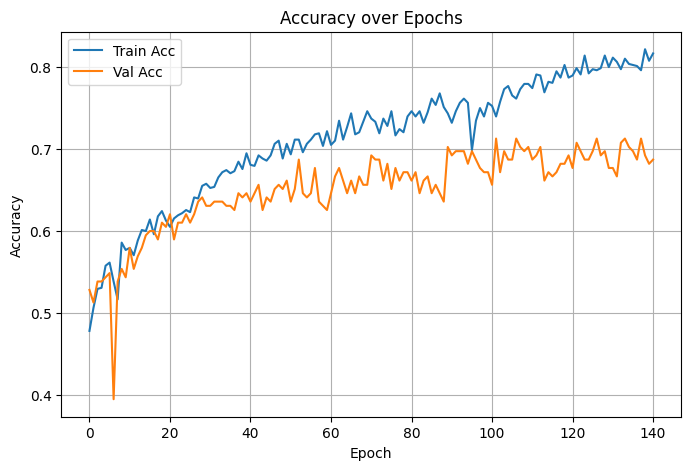

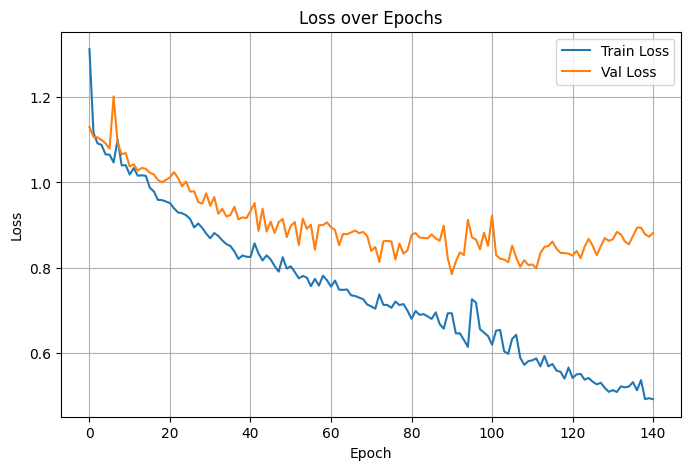

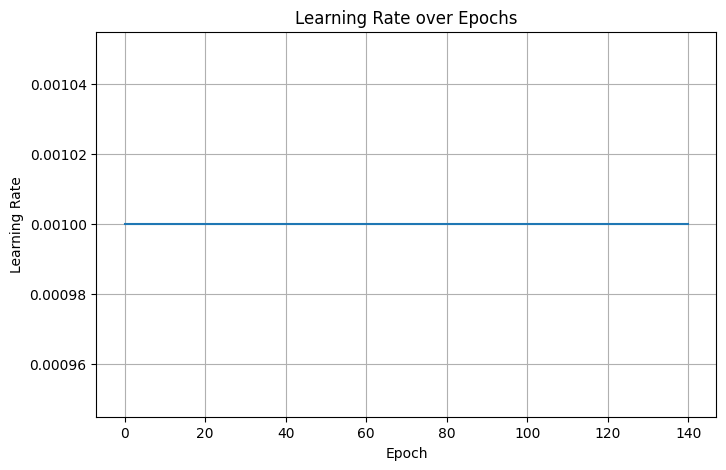

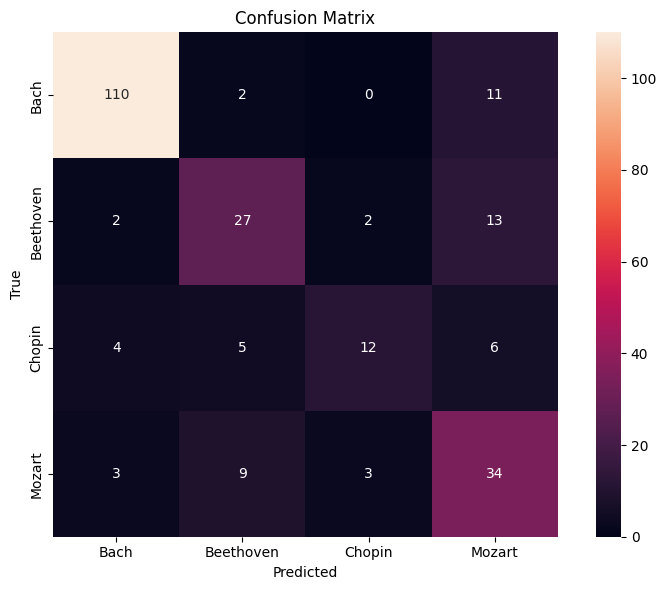

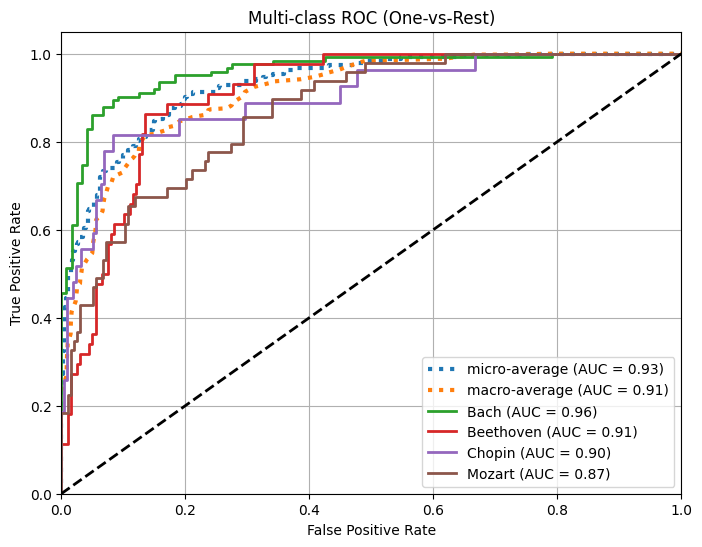

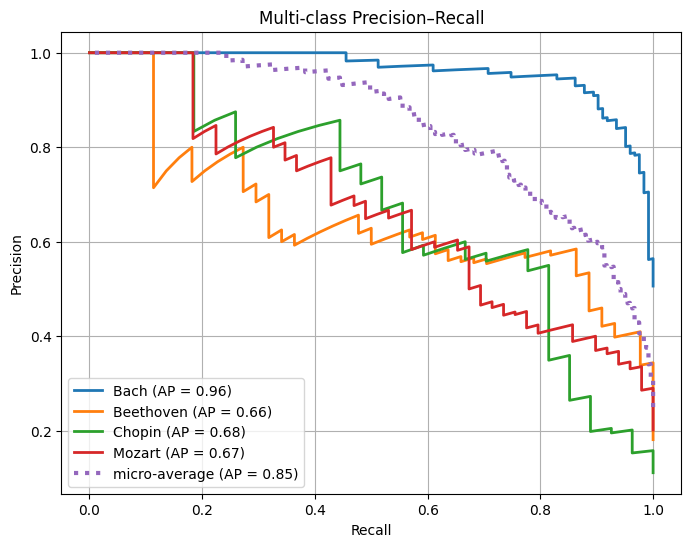

              precision    recall  f1-score   support

        Bach     0.9244    0.8943    0.9091       123
   Beethoven     0.6279    0.6136    0.6207        44
      Chopin     0.7059    0.4444    0.5455        27
      Mozart     0.5312    0.6939    0.6018        49

    accuracy                         0.7531       243
   macro avg     0.6974    0.6616    0.6693       243
weighted avg     0.7671    0.7531    0.7545       243

Top-1 accuracy: 0.7531
Top-2 accuracy: 0.9095
Top-3 accuracy: 0.9671
Total params     : 9,728,548
Trainable params : 9,728,548
Non-trainable    : 0


In [38]:
y_proba = predict_cnn_proba(trained_model, X_test_roll, X_test_stats)

y_pred = np.argmax(y_proba, axis=1)
y_true = np.argmax(y_test, axis=1)


plot_training_history_cnn(history)

plot_learning_rate_cnn(history)

plot_confusion_matrix_cnn(y_true, y_pred, COMPOSERS, normalize=None)

plot_multiclass_roc_cnn(y_true, y_proba, COMPOSERS)

plot_multiclass_pr_cnn(y_true, y_proba, COMPOSERS)

print_classification_report_cnn(y_true, y_pred, COMPOSERS)

summarize_topk_accuracy_cnn(y_true, y_proba, ks=(1,2,3))

summarize_model_params_cnn(trained_model)

# Model Summary

This architectural design deliberately integrates fine-grained symbolic structure learned by convolutional kernels with global statistical descriptors, leveraging both micro-level temporal patterns and macro-level stylistic trends for improved classification robustness in symbolic music data.


1) Piano-roll branch — local feature extraction
Input: (None, 128, 150, 4) — 128 MIDI pitches × 150 time steps × 4 channels (binary activation, normalized velocity, instrument count, expressive span).

Conv2D(32, 3×3, ReLU) → (None, 128, 150, 32) • 1,184 params
Extracts foundational pitch–time motifs.

MaxPooling2D(2×2) → (None, 64, 75, 32)
Downsamples while retaining key patterns.

Conv2D(64, 3×3, ReLU) → (None, 64, 75, 64) • 18,496 params
Captures richer temporal/harmonic dependencies.

MaxPooling2D(2×2) → (None, 32, 37, 64)
Further condensation of features.

Flatten → (None, 75,776)
Prepares a single vector for fusion.

2) Statistical branch — global descriptor processing
Input: (None, 10) — global note statistics (e.g., pitch/velocity/tempo aggregates).

Dense(64, ReLU) → (None, 64) • 704 params
Learns high-level patterns from global descriptors.

3) Fusion & classification
Concatenate(Flattened CNN, Stats) → (None, 75,840)
Combines local motifs with global style cues.

Dense(128, ReLU) → (None, 128) • 9,707,648 params
Models interactions between local and global features.

Dropout(0.4) → (None, 128)
Regularizes to reduce overfitting.

Dense(4, Softmax) → (None, 4) • 516 params
Outputs class probabilities for the four composers.

Parameter footprint (from your summary)
Total params: 29,185,646

Trainable: 9,728,548

Non-trainable: 0

Optimizer params: 19,457,098

In [39]:
trained_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ roll_input          │ (None, 128, 150,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 150,  │      1,184 │ roll_input[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 75,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 75,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 37,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stats_input         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 75776)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │        704 │ stats_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 75840)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │  9,707,648 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 4)         │        516 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,185,646 (111.33 MB)

 Trainable params: 9,728,548 (37.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,457,098 (74.22 MB)

In [40]:
NB_END = datetime.now()
elapsed = NB_END - NB_START

# minutes & seconds
total_seconds = int(elapsed.total_seconds())
mins, secs = divmod(total_seconds, 60)

print(f"Finished at: {NB_END:%Y-%m-%d %H:%M:%S}")
print(f"Elapsed: {mins} min {secs} sec")

Finished at: 2025-08-10 07:22:54
Elapsed: 46 min 42 sec
